# Comparons les différentes méthodes de régressions symboliques

## Pour le probleme 3 : modele expert avec txz


### Import des données, des librairies et def des fonctions

In [134]:
import os 
os.chdir('/vol/usersmeca2/challier')
os.getcwd()

'/vol/usersmeca2/challier'

In [135]:
import UTILS.TOOLS.fct_readsunfluidhdata as rsd # import the reading routines as rsd
import matplotlib.pyplot as plt
import numpy as np
from UTILS.TOOLS.tools_hdf5_m import *
import h5py
from pathlib import Path
from UTILS.TOOLS.tools_subplot import *
import matplotlib.colors as mcolors
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
#from pysindy import FiniteDifference
import pysindy as ps
import kan
import torch
import time
from torch import autograd
from tqdm import tqdm

plt.rcParams.update({ # +6partout, +4 titres, -2 ticks&legend, +2 axeslabel, +4partout
    'font.size': 24,            # Police globale plus grande
    'axes.titlesize': 30,       # Titres d'axes bien visibles
    'axes.labelsize': 26,       # Labels d'axes
    'xtick.labelsize': 20,      # Taille des ticks
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
    'font.family': 'serif',
    'font.serif': ['DejaVu Serif'],
    'mathtext.fontset': 'dejavuserif',
    "text.usetex": False,
    # "font.family": "serif",
    # "font.serif": ["Computer Modern Roman"],
    # 'mathtext.fontset': 'cm',
    'lines.linewidth': 2,
    'axes.linewidth': 1.2,
    'axes.edgecolor': 'black',
    'axes.grid': False,
    'grid.linestyle': '--',
    'grid.alpha': 0.6,
    'legend.frameon': True,
    'figure.dpi': 150,           # Pour une meilleure résolution
    'savefig.dpi': 300,          # Pour les figures exportées
})

# recupère les coupes
def recup_slices(n_run, slicedir, sliceid, idtime, nlaps, champs): 
    datafilename = f"/workdir/challier/SLICE_H5_RUN{n_run}" + f'/slice_{sliceid:02d}_' + f'{slicedir}_' + f'{idtime:07d}' + '.h5'
    #keys_file=Read_H5_Spav(datafilename,keyreading=True)
    xxh,yyh=Read_H5_Spav(datafilename,gridreading=True)


    slices = np.zeros([len(xxh), len(yyh), len(nlaps), len(champs)])
    tt = np.zeros(len(nlaps))


    for n in range(len(nlaps)):  
        idtime = nlaps[n]
        datafilename = f"/workdir/challier/SLICE_H5_RUN{n_run}" + f'/slice_{sliceid:02d}_' + f'{slicedir}_' + f'{idtime:07d}' + '.h5'
        

        for i, c in enumerate(champs) : 
            time,fields=Read_H5_Spav(datafilename, c)
            slices[:,:, n, i] = fields

        tt[n] = time


    return slices, xxh, yyh, tt

# normalisation
def normalize(X):
    if type(X)==np.ndarray:
        X_mean = np.mean(X, axis=(0, 1, 2))
        X_std = np.std(X, axis=(0, 1, 2))
    elif type(X)==torch.Tensor:
        X_mean = torch.mean(X, axis=[0, 1, 2])
        X_std = torch.std(X, axis=[0, 1, 2])
    else:
        raise ValueError('Type not supported')
    X_normed = (X - X_mean )/ X_std
    return X_normed, X_mean, X_std

def unormalize(X_normed, X_mean, X_std):
    X_unormed = X_normed * X_std + X_mean
    return X_unormed

def reshp(X):
    return X.reshape(X.shape[0]*X.shape[1], X.shape[2])

# device cpu pour grappe
device = 'cpu'

Import des données et découpe de la slice.

In [136]:
# run 1

########## Parametres des slices ##########
n_run = 1
slicedir = 2
sliceid = 7
idtime = 5886

## temps run1 : 5886 
## temps run2 : 6353
## temps run3 : 6820 (ntime=466)
## temps run4 : 7286

ntime = 467 # number of instants (nombre)
nfin = int(idtime+ntime-1) # issue of instants (numero fin)
nech=1

nlaps = np.arange (idtime,nfin+1,nech)
champs = ['U','W','T']
##########################################

## recupere les slices

slices_r1, xxh, zzh, tt_r1 = recup_slices(n_run, slicedir, 
                            sliceid, idtime, nlaps, champs)

### coupe la slice
# - 320 : prend le x au centre 
# - [:125] : zoom sur le z pour avoir que les 0.1 prems
# - [293:393] : prend un bout de temps -> 293.5 to 295.5
# - [268:368] : prend un bout de temps -> 293 to 295
# - [121:368] : prend un bout de temps -> 290.0 to 295
# - garde tous les champs

X = slices_r1[315:325,:16,194:368,:].astype(np.float32)
x = xxh[315:325].astype(np.float32)
t = tt_r1[194:368].astype(np.float32)
z = zzh[:16].astype(np.float32)
num_pb = 77 # 1 pour [293.5, 295.5] et 12 pour [293.0, 295.0]
            # 13 pour 290-292 -> 194:368 et 24 pour l'ajout de x en plus ou laors faire un autre notebook ?
############

cond_lim = True 
if cond_lim :
    # ajout des cond limites en z=0

    a = np.zeros((len(x), 1, len(t), 2)) #+ 1e-5
    b = np.ones((len(x), 1,  len(t), 1))
    A = np.concatenate((a, b), axis=-1)

    X= np.concatenate((A, X), axis=1)
    z= np.concatenate((np.zeros(1), z))

    # il faudrait que j'interpole pour les z entre z=0 et z[0] ?
# X = np.transpose(X, axes=(1,0,2))
X.shape # dimension (x, z, t, champs)
X = np.transpose(X, (2, 0, 1, 3))
X.shape # dimension (t, x, z, champs) ou (t, z, champs)


(174, 10, 17, 3)

In [137]:
# créer notre label y : les dérivées verticales
y = np.gradient(X[:,:,:,[0,2]], z, axis=2, edge_order=2)

# calcule les derivées spatiales : pour les KANs, SINDy les calculs directements avec la librairie de fonction pour les PDEs
Xt = np.gradient(X, t, axis=0, edge_order=2) 
Xtt = np.gradient(Xt, t, axis=0, edge_order=2) 
Xx = np.gradient(X, x, axis=1, edge_order=2) 
Xxx = np.gradient(Xx, x, axis=1, edge_order=2)

# sort le maillage pour les KANs et la librairie WeakPDE # ptetre pas utile ? nan pas utile
TIME, Z = np.meshgrid(t, z)
ZT = np.concatenate(( Z.reshape(len(z), len(t), 1), TIME.reshape(len(z), len(t), 1)), axis=2) 

# et créer la matrice d'entrée pour les KANs et la convertit en tenseur plus tard
X_kan = np.concatenate((X, Xt, Xx, Xxx), axis=-1)
X_sindy = X
y_kan = y
y_sindy = y

# normalisation des données 
normalisation = True
if normalisation : # pour les KANs, + SINDy aussi //SINDy normalise directement dans l'entraînement//
    X_kan, mean_X_kan, std_X_kan = normalize(X_kan)
    #y_kan, mean_y_kan, std_y_kan = normalize(y_kan)
    #X_sindy, mean_X_sindy, std_X_sindy = normalize(X_sindy) ## X et y reste sans normalisation => utile pour les visualisations
    #y_sindy, mean_y_sindy, std_y_sindy = normalize(y_sindy)

# split train/test 0.70/0.30%
tscv = TimeSeriesSplit(n_splits=2, test_size=int(t.size*0.3))
all_splits = list(tscv.split(t))
train_id, test_id = all_splits[1]   # prend train 0-79 et test 80-99

# split KANs dans un dictionnaire
# on ne peut pas utiliser le create_datasets_from_data de kan 
# car il y a un random.choice qui n'est pas compatible pour les TimesSeries
nb_features = X_kan.shape[-1]
data_kan = {} # on reshape directement les données // ptetre fonctionne sans reshape ?? NON forcément (nb_obs, nb_features)
data_kan['train_input'] = torch.tensor(X_kan[train_id,:,:].reshape(len(x)*len(z)*len(train_id), nb_features), dtype=torch.float32, device=device)
data_kan['test_input'] = torch.tensor(X_kan[test_id,:,:].reshape(len(z)*len(x)*len(test_id), nb_features), dtype=torch.float32, device=device)
data_kan['train_label'] = torch.tensor(y_kan[train_id,:,:].reshape(len(z)*len(x)*len(train_id), 2), dtype=torch.float32, device=device)
data_kan['test_label'] = torch.tensor(y_kan[test_id,:,:].reshape(len(z)*len(test_id)*len(x), 2), dtype=torch.float32, device=device)

# split SINDy
X_train = X_sindy[train_id]
X_test = X_sindy[test_id]
y_train = y_sindy[train_id]
y_test = y_sindy[test_id]
t_train, t_test = t[train_id], t[test_id]  



## Définition et entraînement des modèles 

Maintenant que les données sont préparées, nous pouvons définir et entraîner les modèles.
Il faut créer les librairies de fonctions pour les modèles SINDy et WeakSINDy.
Définir les optimiseurs et leurs paramètres.

Les modèles ont les mêmes données d'entrée. Cependant, on ne leur donne pas de la même manière. SINDy construit une librairie de fonctions avec les dérivées spatiales en $z$ et prends des données d'entrée de dimension $(125, 100, 3)$ avec nos trois champs $[u, w, T]$. Alors que pour les KANs il faut applatir les données d'entrée, on ajoute le maillage de la fonction `np.meshgrid(t, z)` pour que le modèles puisse prendre en compte la struction spatio-temporelle des données. De plus, il faut ajouter les dérivées spatiales en $z$ pour que le modèle ait autant d'information que SINDy. On se retrouve donc avec une matrice d'entrée de dimension $(125 \times 100, 11)$.

### Les hyperparamètres 

Pour le modèle SINDy :
- library_functions : librairie de fonctions
- derivative order : ordre de dérivée
- include_bias : inclure un terme de biais
- include_interaction : autoriser les interactions entre les fonctions
- K : nombre de sous-domaines pour la formulation faible des PDEs

Pour le modèle KAN : 
- width : profondeur du réseau et nombre de neurones
- grid : nombre d'intervalles pour les splines
- k : ordre des polynômes

Pour l'optimisation : 
- optimizer : optimiseur de la fonction de coût
- threshold : seuil de coût

### PDE-SINDy

In [216]:
x

array([0.48515624, 0.48671874, 0.48828125, 0.48984376, 0.49140626,
       0.49296874, 0.49453124, 0.49609375, 0.49765626, 0.49921876,
       0.50078124, 0.5023438 , 0.50390625, 0.5054687 , 0.50703126,
       0.50859374, 0.5101563 , 0.51171875, 0.5132812 , 0.51484376],
      dtype=float32)

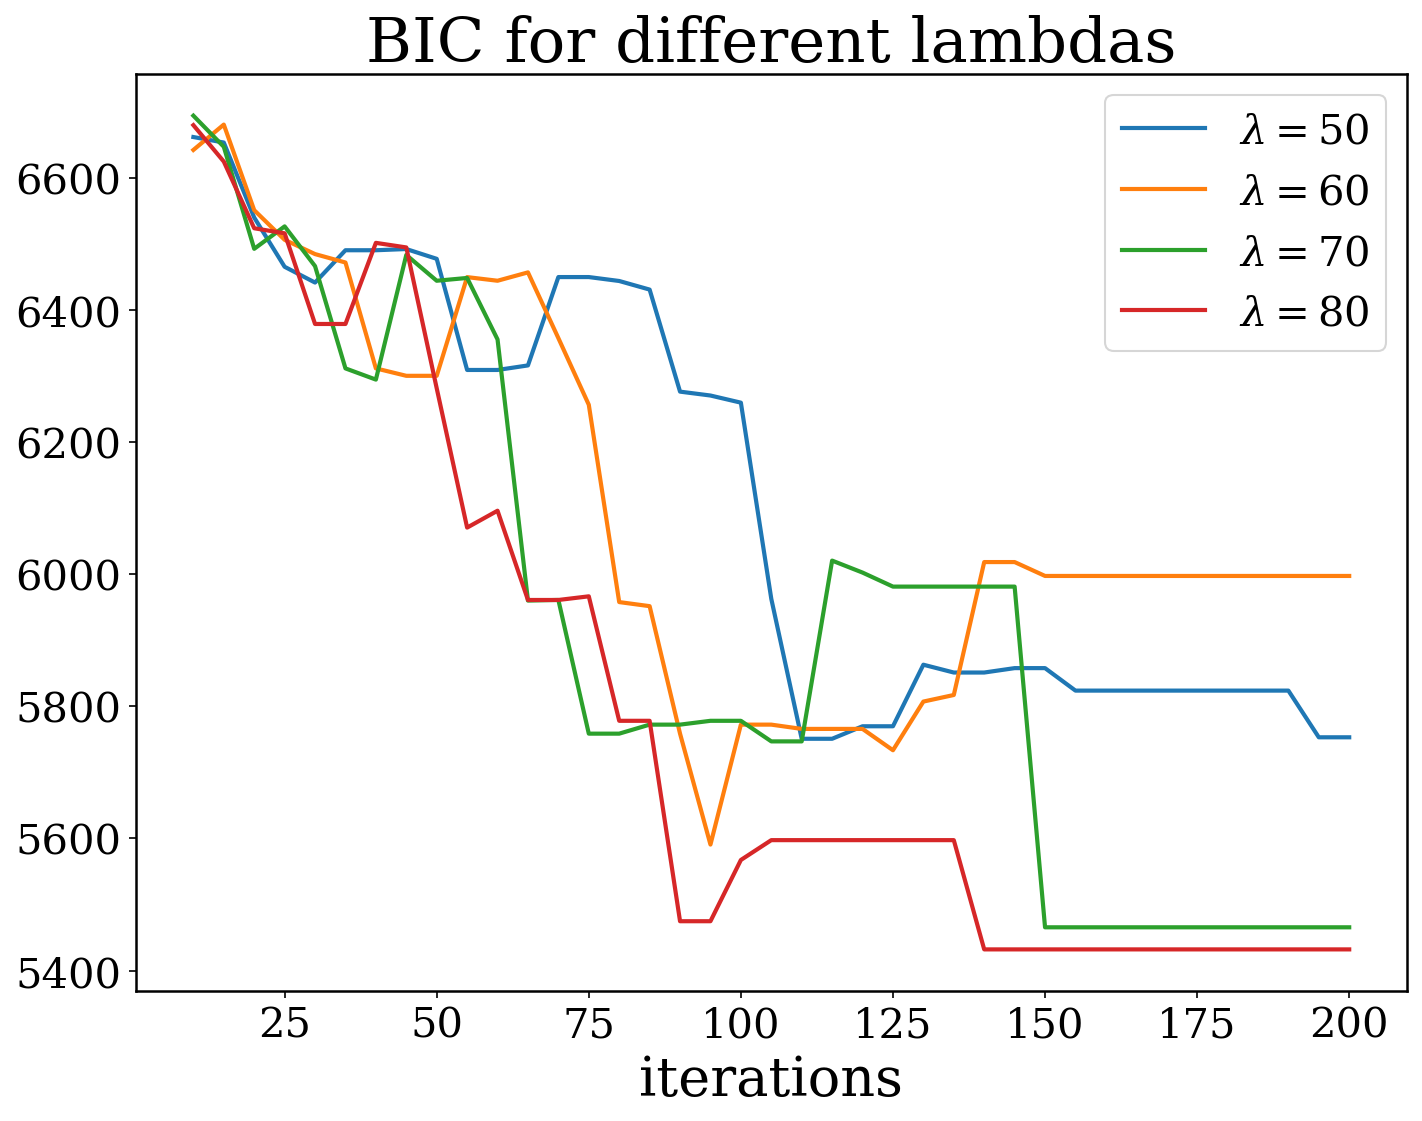

In [138]:
# choix de lambda
#lamb_list = [5, 10, 20, 30]
lamb_list = [50, 60, 70, 80]

#lamb_list = [0.1, 0.5, 1]
nu_list = [1]
np.random.seed(1501)

plt.figure(figsize=(10, 8))
ax1 = plt.subplot(111)
#ax2 = plt.subplot(122)

du_train = y_train#[:,:,:,1].reshape(len(t_train), len(x), len(z), 1)
du_test = y_test#[:,:,:,1].reshape(len(t_test), len(x), len(z), 1)

for lamb in lamb_list : 
    for nu in nu_list : 
        # SINDy avec PDELibrary
        # création des librairies de fonctions

        library_functions = [lambda x: x]
        library_function_names = [lambda x: x]

        multi_ind = np.array([ # order for the derivative terms
                        [1, 0], # first derivative in t
                        [0, 1], # first derivative in x
                        #[2, 0], # second derivative in t
                        [0, 2], # second derivative in x
                        ])
        
        # pour SINDy 
        pde_lib = ps.PDELibrary(library_functions=library_functions, 
                                function_names=library_function_names, 
                                derivative_order=1, 
                                spatial_grid=t_train, # grille temporelle
                                include_bias=True,
                                include_interaction=True,
                                is_uniform=False,
                                implicit_terms=True, 
                                temporal_grid=x, # grille pour les dérivées
                                multiindices=multi_ind,
                                )
        
        pde_lib_test = ps.PDELibrary(library_functions=library_functions, 
                                function_names=library_function_names, 
                                derivative_order=1, 
                                spatial_grid=t_test, # grille temporelle 
                                include_bias=True,
                                include_interaction=True,
                                is_uniform=False,
                                implicit_terms=True, 
                                temporal_grid=x, # grille pour les dérivées
                                multiindices=multi_ind,
                )

        ### Pour SR3
        ## Pour STLSQ on a juste a modif opt_sindy et les titres

        MAE_train, MAE_test = [], []
        R2_train, R2_test = [], []
        MSE_train, MSE_test = [], []
        MAPE_train, MAPE_test = [], []
        compl = []
        n_iters = 200

        opt_sindy = ps.SR3(threshold=lamb, thresholder='l1', normalize_columns=True, max_iter=n_iters, verbose=False, tol=1e-5, nu=nu)
        # opt_sindy = ps.STLSQ(threshold=30, alpha=1e-5, normalize_columns=True, verbose=False, max_iter=n_iters)
        model_sindy = ps.SINDy(feature_library=pde_lib, optimizer=opt_sindy, feature_names=['u', 'w', 'T'])

        iters = range(10, n_iters+1, 5)
        for i in iters:
            # opt_sindy = ps.SR3(threshold=2, thresholder='l1', normalize_columns=True, max_iter=i, verbose=False, tol=1e-5, nu=1)
            # # opt_sindy = ps.STLSQ(threshold=30, alpha=1e-5, normalize_columns=True, verbose=False, max_iter=n_iters)
            # model_sindy = ps.SINDy(feature_library=pde_lib, optimizer=opt_sindy, feature_names=['u', 'w', 'T'])
            model_sindy.optimizer.max_iter = i
            model_sindy.fit(X_train, x_dot=du_train, quiet=True)

            # metric train/test
            coef = model_sindy.coefficients()
            train_transf = pde_lib.fit_transform(X_train)
            train_pred = train_transf @ coef.T
            test_transf = pde_lib_test.fit_transform(X_test)
            test_pred = test_transf @ coef.T
            MAE_train.append(np.mean(np.abs(train_pred-du_train)))
            MAE_test.append(np.mean(np.abs(test_pred-du_test)))
            R2_train.append(1 - np.mean((train_pred-du_train)**2) / np.mean((du_train - du_train.mean(axis=(0, 1, 2)))**2)  )
            R2_test.append(1 - np.mean((test_pred-du_test)**2) / np.mean((du_test - du_test.mean(axis=(0, 1, 2)))**2)  )
            MSE_train.append(np.mean((train_pred-du_train)**2))
            MSE_test.append(np.mean((test_pred-du_test)**2))
            # MAPE_train.append(model_sindy.score(X_train, t=dt, metric=mean_absolute_percentage_error))
            # MAPE_test.append(model_sindy.score(X_test, t=dt, metric=mean_absolute_percentage_error))
            compl.append(model_sindy.complexity)

        nb_coeff = model_sindy.coefficients().shape
        n_train = len(t_train) * len(z)
        n_test = len(t_test)* len(z)
        AIC_test = n_test * np.log(MSE_test) + 2* np.array(compl)
        AIC_train = n_train * np.log(MSE_train) + 2* np.array(compl)
        BIC_test = n_test * np.log(MSE_test) + np.log(n_test)* np.array(compl)
        BIC_train = n_train * np.log(MSE_train) + np.log(n_train)* np.array(compl)

        # print(r"Modèle SINDy-PDE avec SR3:")
        # print("     Nombre de coefficients d'apprentissage :", nb_coeff)
        # print("     Complexité du modèle :", compl[-1])
        # print("     R2 score | training : ", R2_train[-1], "| testing : ", R2_test[-1]) # r2 
        # print("     MSE score | training : ", MSE_train[-1], "| testing : ", MSE_test[-1]) # r2 
        # print("     MAE score | training : ", MAE_train[-1], "| testing : ", MAE_test[-1]) # mse
        # print("     BIC : ", BIC_train[-1], "| AIC : ", AIC_train[-1])
        # print('\n\n')
        # model_sindy.print()

        ax1.plot(iters, BIC_test, label=r'$\lambda=$'+f'{lamb}')
        #ax2.plot(iters, R2_test)




ax1.legend()
plt.title('BIC for different lambdas')
ax1.set_xlabel('iterations')
plt.tight_layout()

plt.savefig(f'FIGURES/pb{num_pb}_bic_sindy.png', dpi=300, bbox_inches='tight', transparent=True)

plt.savefig(f'FIGURES/pb{num_pb}_bic_sindy.pdf', bbox_inches='tight', transparent=True)
plt.show()

In [139]:
# SINDy avec PDELibrary
# création des librairies de fonctions
library_functions = [lambda x: x, 
                    #lambda x: 1/x, 
                    ]
library_function_names = [lambda x: x,
                        #lambda x: "1/"+x,
                        ]

multi_ind = np.array([ # order for the derivative terms
                [1, 0], # first derivative in t
                [0, 1], # first derivative in x
                #[2, 0], # second derivative in t
                [0, 2], # second derivative in x
                ])

# pour SINDy 
pde_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=1, 
                        spatial_grid=t_train, # grille temporelle
                        include_bias=True,
                        include_interaction=True,
                        is_uniform=False,
                        implicit_terms=True, 
                        temporal_grid=x, # grille pour les dérivées
                        multiindices=multi_ind,
                        )

pde_lib_test = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=1, 
                        spatial_grid=t_test, # grille temporelle 
                        include_bias=True,
                        include_interaction=True,
                        is_uniform=False,
                        implicit_terms=True, 
                        temporal_grid=x, # grille pour les dérivées
                        multiindices=multi_ind,
        )

### Pour SR3
## Pour STLSQ on a juste a modif opt_sindy et les titres

MAE_train, MAE_test = [], []
R2_train, R2_test = [], []
MSE_train, MSE_test = [], []
MAPE_train, MAPE_test = [], []
compl = []
n_iters = 90

du_train = y_train#[:,:,:,1].reshape(len(t_train), len(x), len(z), 1)
du_test = y_test#[:,:,:,1].reshape(len(t_test), len(x), len(z), 1)

opt_sindy = ps.SR3(threshold=70, thresholder='l1', normalize_columns=False, max_iter=n_iters, verbose=False, tol=1e-5, nu=1)
# opt_sindy = ps.STLSQ(threshold=30, alpha=1e-5, normalize_columns=True, verbose=False, max_iter=n_iters)
model_sindy = ps.SINDy(feature_library=pde_lib, optimizer=opt_sindy, feature_names=['u', 'w', 'T'])
sindy_iters_complet = range(1, n_iters+1)
sindy_iters = range(10, n_iters+1, 5)
for i in sindy_iters:
    model_sindy.optimizer.max_iter = i
    model_sindy.fit(X_train, x_dot=du_train , quiet=True)
    
    # metric train/test
    coef = model_sindy.coefficients()
    train_transf = pde_lib.fit_transform(X_train)
    train_pred = train_transf @ coef.T
    test_transf = pde_lib_test.fit_transform(X_test)
    test_pred = test_transf @ coef.T
    MAE_train.append(np.mean(np.abs(train_pred-du_train)))
    MAE_test.append(np.mean(np.abs(test_pred-du_test)))
    R2_train.append(1 - np.mean((train_pred-du_train)**2) / np.mean((du_train - du_train.mean(axis=(0, 1, 2)))**2)  )
    R2_test.append(1 - np.mean((test_pred-du_test)**2) / np.mean((du_test - du_test.mean(axis=(0, 1, 2)))**2)  )
    MSE_train.append(np.mean((train_pred-du_train)**2))
    MSE_test.append(np.mean((test_pred-du_test)**2))
    compl.append(model_sindy.complexity)

nb_coeff = model_sindy.coefficients().shape

mae_train = opt_sindy.mae_history
mse_train = opt_sindy.mse_history
r2_train = opt_sindy.r2_history
compl_hist = np.count_nonzero(np.array(opt_sindy.history_), axis=(1, 2))[:-1]
sindy_mse_train = mse_train
sindy_mse_test = MSE_test
sindy_mae_train = mae_train
sindy_mae_test = MAE_test
sindy_r2_train = r2_train
sindy_r2_test = R2_test
sindy_compl = compl_hist

print(r"Modèle SINDy-PDE avec SR3:")
print("     Nombre de coefficients d'apprentissage :", nb_coeff)
print("     Complexité du modèle :", compl_hist[-1])
print("     R2 score | training : ", R2_train[-1], "| testing : ", R2_test[-1]) # r2 
print("     MSE score | training : ", MSE_train[-1], "| testing : ", MSE_test[-1]) # r2 
print("     RMSE score | training : ", np.sqrt(MSE_train[-1]), "| testing : ", np.sqrt(MSE_test[-1])) # r2 
print("     MAE score | training : ", MAE_train[-1], "| testing : ", MAE_test[-1]) # mse
print('\n\n')
model_sindy.print()


Modèle SINDy-PDE avec SR3:
     Nombre de coefficients d'apprentissage : (2, 40)
     Complexité du modèle : 14
     R2 score | training :  0.6205734117846405 | testing :  0.5274724561046351
     MSE score | training :  184.2119564070047 | testing :  348.31402741853805
     RMSE score | training :  13.572470534394418 | testing :  18.663173026539138
     MAE score | training :  10.210724330244878 | testing :  13.607735836997831



(u)' = 120.350 u
(w)' = 140.430 u + -1041.069 w + -83.790 T + 22.008 u_1 + -45.874 uT_1 + -35.446 ww_1 + 68.847 Tu_1 + -106.329 uw_t + -14.933 uT_t + 72.401 wu_t + -8.799 wT_t + -17.126 Tu_t + 126.378 Tw_t


In [140]:
sindy_iters_complet
len(mse_train)

90

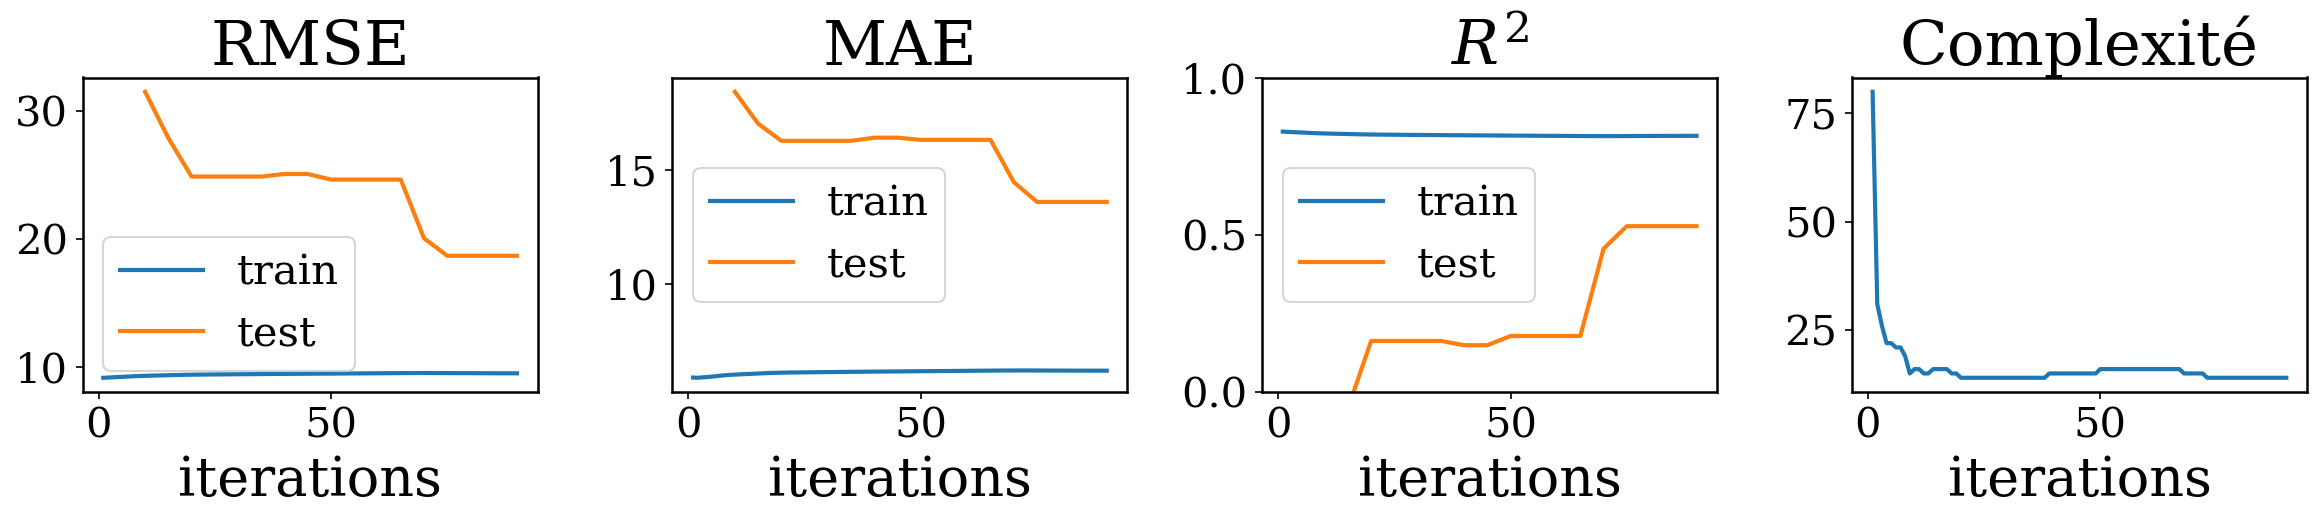

In [141]:
fig = plt.figure(figsize=(16, 4))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1])

mae_train = opt_sindy.mae_history
mse_train = opt_sindy.mse_history
r2_train = opt_sindy.r2_history
compl_hist = np.count_nonzero(np.array(opt_sindy.history_), axis=(1, 2))[:-1]

#fig.suptitle(r"Evaluation de PDE-SINDy avec SR3($R=\ell_1$, $\lambda=1$, $\nu=1$)")
iters_complet = np.arange(1, n_iters+1)
ax0 = fig.add_subplot(gs[0])
ax0.plot(sindy_iters_complet, np.sqrt(mse_train), label='train')
ax0.plot(sindy_iters, np.sqrt(MSE_test), label='test')
ax0.legend()
ax0.set_title(r'RMSE')
ax0.set_xlabel('iterations')

ax1 = fig.add_subplot(gs[1])
ax1.plot(sindy_iters_complet, mae_train, label='train')
ax1.plot(sindy_iters, MAE_test, label='test')
ax1.legend()
ax1.set_title(r'MAE')
ax1.set_xlabel('iterations')

ax2 = fig.add_subplot(gs[2])
ax2.plot(sindy_iters_complet, r2_train, label='train')
ax2.plot(sindy_iters, R2_test, label='test')
# ax2.plot(70 * np.log(np.array(opt_sindy.mse_history)) + 2 * compl_hist) 
# ax2.plot(iters, compl, label='complexity')
# ax2.plot(iters, BIC_train, label='Btrain')
# ax2.plot(iters, BIC_test, label='Btest')
ax2.set_title(r'$R^2$')
ax2.set_ylim(0,1)
ax2.legend()
ax2.set_xlabel('iterations')

ax3 = fig.add_subplot(gs[3])
# ax3.plot(iters, AIC_train, label='train')
# ax3.plot(iters, AIC_test, label='test')
ax3.plot(sindy_iters_complet, compl_hist, label='complexity')
# ax2.plot(iters, BIC_train, label='Btrain')
# ax2.plot(iters, BIC_test, label='Btest')
ax3.set_title(r'Complexité')
#ax3.legend()
ax3.set_xlabel('iterations')

fig.tight_layout()

plt.savefig(f'FIGURES/pb{num_pb}_metrics_sindy.png', dpi=300, bbox_inches='tight', transparent=True)

plt.savefig(f'FIGURES/pb{num_pb}_metrics_sindy.pdf', bbox_inches='tight', transparent=True, backend='pdf')
plt.show()




In [142]:
du_coef = model_sindy.coefficients()
du_train_transf = pde_lib.fit_transform(X_train)
du_train_pred = train_transf @ coef.T
du_test_transf = pde_lib_test.fit_transform(X_test)
du_test_pred = test_transf @ coef.T
du_pred_sindy = np.concatenate((train_pred, test_pred), axis=0)

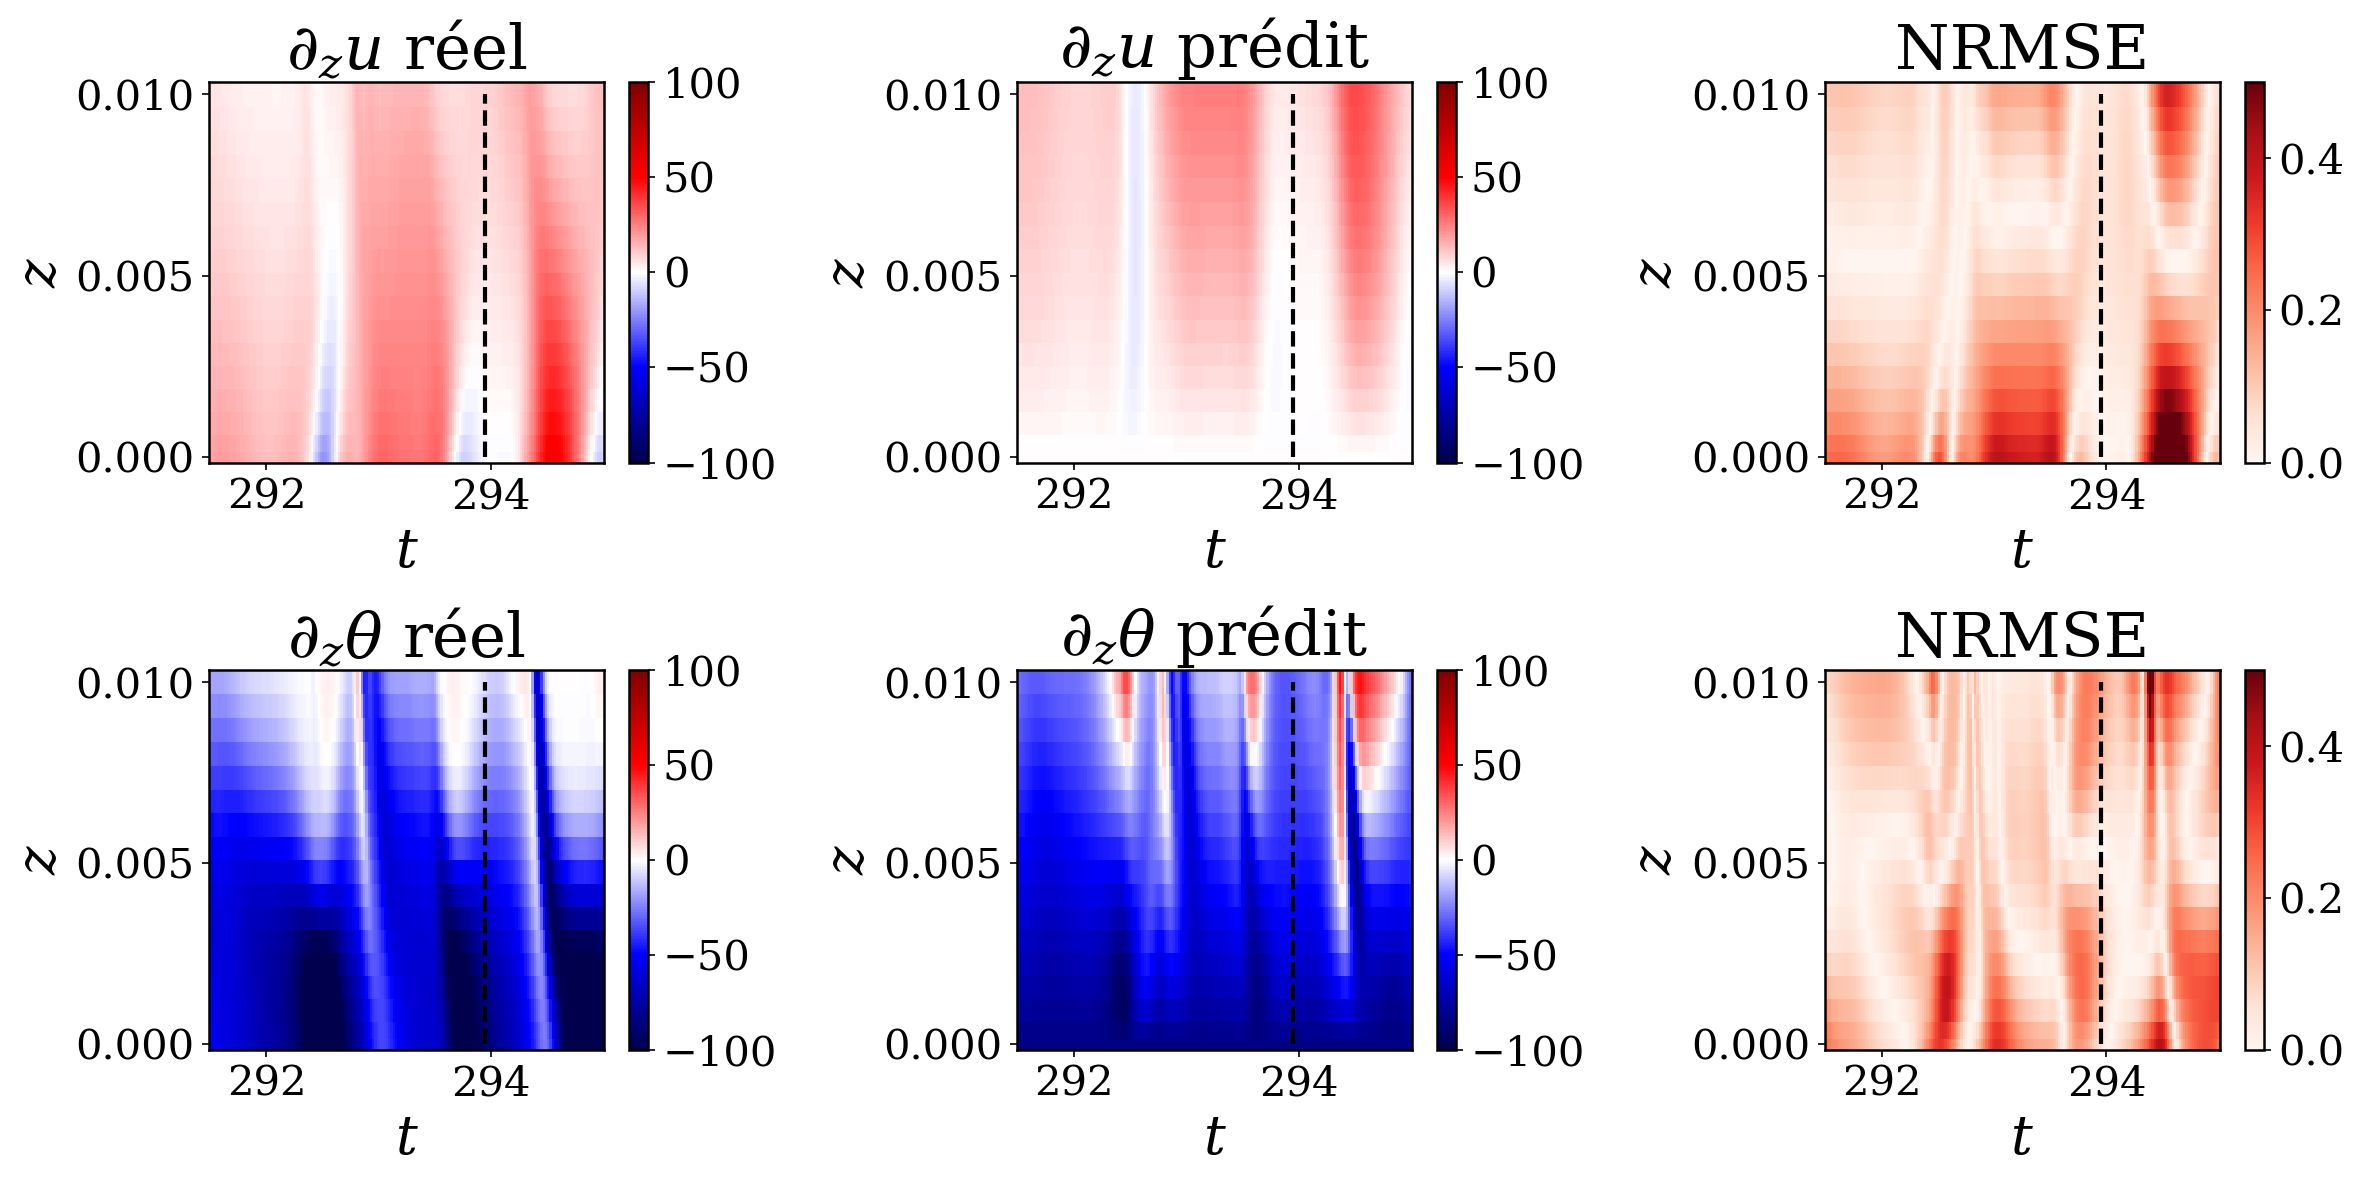

In [143]:
# SINDy

fig = plt.figure( figsize=(16,8))
ax1 = plt.subplot(2,3,1)
ax2 = plt.subplot(2,3,2)
ax3 = plt.subplot(2,3,3)
ax4 = plt.subplot(2,3,4)
ax5 = plt.subplot(2,3,5)
ax6 = plt.subplot(2,3,6)

res_norm = mcolors.Normalize(vmin=0.0, vmax=0.5)
norm = mcolors.TwoSlopeNorm(vmin=-100.0, vcenter=0.0, vmax=100.0)
coef = model_sindy.coefficients()
train_transf = pde_lib.fit_transform(X_train)
train_pred = train_transf @ coef.T
test_transf = pde_lib_test.fit_transform(X_test)
test_pred = test_transf @ coef.T
pred_sindy = np.concatenate((train_pred, test_pred), axis=0)

x_fixed = x.size//2

im1 = ax1.pcolor(t, z, y_sindy[:,x_fixed,:,0].T, cmap='seismic', norm=norm)
ax1.vlines(t[train_id[-1]], (z[0]), (z[-1]), ls='dashed', colors='k', linewidth=2)
plt.colorbar(im1, ax=ax1)
ax1.set_title(r"$\partial_z u$ réel")
ax1.set_ylabel('$z$')
ax1.set_xlabel('$t$')


im2 = ax2.pcolor(t, (z), pred_sindy[:,x_fixed,:,0].T, cmap='seismic', norm=norm)
ax2.vlines(t[train_id[-1]], z[0], z[-1], ls='dashed', colors='k', linewidth=2)
plt.colorbar(im2, ax=ax2)
ax2.set_title(r"$\partial_z u$ prédit")
ax2.set_ylabel('$z$')
ax2.set_xlabel('$t$')


im3 = ax3.pcolor(t, (z), (np.sqrt((y_sindy[:,x_fixed,:,0]-pred_sindy[:,x_fixed,:,0])**2)/(y_sindy[:,x_fixed,:,0].max() - y_sindy[:,x_fixed,:,0].min())).T, cmap='Reds', norm=res_norm)
ax3.vlines(t[train_id[-1]], z[0], z[-1], ls='dashed', colors='k', linewidth=2)
plt.colorbar(im3, ax=ax3)
ax3.set_title(r"NRMSE")
ax3.set_ylabel('$z$')
ax3.set_xlabel('$t$')

im4 = ax4.pcolor(t, (z), y_sindy[:,x_fixed,:,1].T, cmap='seismic', norm=norm)
ax4.vlines(t[train_id[-1]], (z[0]), (z[-1]), ls='dashed', colors='k', linewidth=2)
plt.colorbar(im4, ax=ax4)
ax4.set_title(r"$\partial_z \theta$ réel")
ax4.set_ylabel('$z$')
ax4.set_xlabel('$t$')


im5 = ax5.pcolor(t, (z), pred_sindy[:,x_fixed,:,1].T, cmap='seismic', norm=norm)
ax5.vlines(t[train_id[-1]], z[0], z[-1], ls='dashed', colors='k', linewidth=2)
plt.colorbar(im5, ax=ax5)
ax5.set_title(r"$\partial_z \theta$ prédit")
ax5.set_ylabel('$z$')
ax5.set_xlabel('$t$')


im6 = ax6.pcolor(t, (z), (np.sqrt((y_sindy[:,x_fixed,:,1]-pred_sindy[:,x_fixed,:,1])**2)/(y_sindy[:,x_fixed,:,1].max() - y_sindy[:,x_fixed,:,1].min())).T, cmap='Reds', norm=res_norm)
ax6.vlines(t[train_id[-1]], z[0], z[-1], ls='dashed', colors='k', linewidth=2)
plt.colorbar(im6, ax=ax6)
ax6.set_title(r"NRMSE")
ax6.set_ylabel('$z$')
ax6.set_xlabel('$t$')

fig.tight_layout(pad=0.5)
plt.savefig(f'FIGURES/pb{num_pb}_res_sindy.png', dpi=300, bbox_inches='tight', transparent=True)

plt.savefig(f'FIGURES/pb{num_pb}_res_sindy.pdf', bbox_inches='tight', transparent=True, backend='pdf')
fig.show()


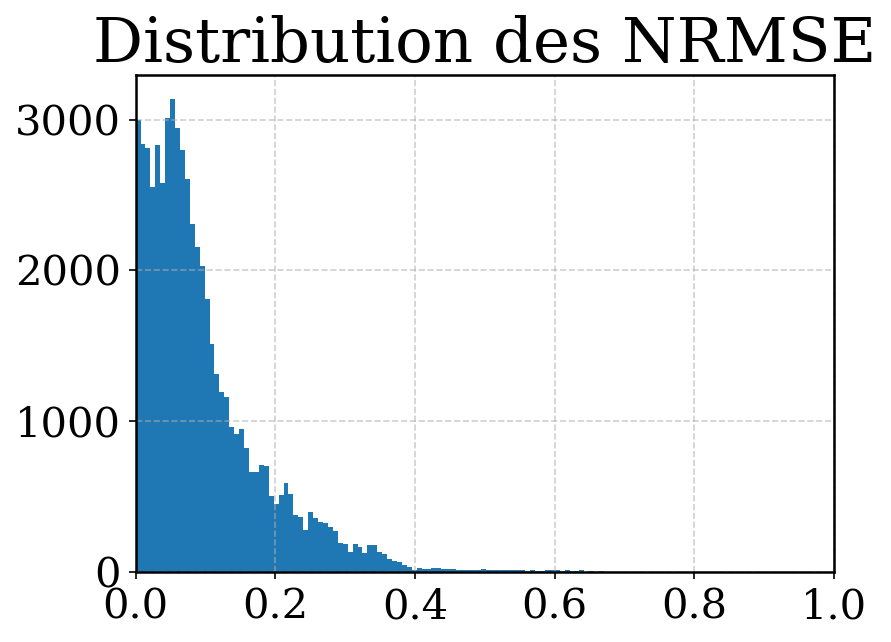

In [144]:

c=0

NRMSE = np.sqrt((y_sindy-pred_sindy)**2)/(y_sindy.max(axis=(0,1, 2)) - y_sindy.min(axis=(0,1, 2)))
plt.hist(NRMSE.flatten(), bins=100)

plt.title("Distribution des NRMSE")
plt.xlim(0, 1)
plt.tight_layout()
plt.grid(True)
plt.savefig(f'FIGURES/pb{num_pb}_nrmse_sindy.png', dpi=300, bbox_inches='tight', transparent=True)

plt.savefig(f'FIGURES/pb{num_pb}_nrmse_sindy.pdf', bbox_inches='tight', transparent=True)
plt.show()


### KAN

voir le fichier exploration_kan.ipynb, version améliorée de ça 


In [169]:
in_vars=['$u$', '$w$', r'$\theta$', 
        r'$\frac{\partial u}{\partial t}$', 
        r'$\frac{\partial w}{\partial t}$', 
        r'$\frac{\partial \theta}{\partial t}$', 
        r'$\frac{\partial u}{\partial x}$', 
        r'$\frac{\partial w}{\partial x}$', 
        r'$\frac{\partial \theta}{\partial x}$', 
        r'$\frac{\partial^2 u}{\partial x^2}$', 
        r'$\frac{\partial^2 w}{\partial x^2}$', 
        r'$\frac{\partial^2 \theta}{\partial x^2}$', ]
out_vars=[r'$\frac{\partial u}{\partial z}$', 
        r'$\frac{\partial \theta}{\partial z}$']
len(in_vars)

12

In [170]:

model = kan.KAN(width=[data_kan['test_input'].shape[-1], [5, 2], 2], grid=3, k=3, seed=1501, sparse_init=False)
np.random.seed(1501)
kan_compl = [12*(5+2*2) + (5+2*2)*2]
var_imp = []
steps_list = [0, 6, 12, 12]
losses = model.fit(
    data_kan, batch=-1, steps=steps_list[1], loss_fn=torch.nn.MSELoss(),
    update_grid = True, grid_update_num=3,
    lr = 5e-1, lamb=10, opt='LBFGS', 
    metrics=[torch.nn.functional.mse_loss, torch.nn.functional.l1_loss], log=1
)
var_imp.append(model.feature_score)
kan_compl.append( (model.edge_scores[0]>1e-5).sum().numpy() + (model.edge_scores[1]>1e-5).sum().numpy() )
#model.refine(6)
model.prune(0.5)
losses2 = model.fit(
    data_kan, batch=-1, steps=steps_list[2], loss_fn=torch.nn.MSELoss(),
    update_grid = False, grid_update_num=1,
    lr = 5e1, lamb=0.1, opt='LBFGS', 
    metrics=[torch.nn.functional.mse_loss, torch.nn.functional.l1_loss], log=1
)
var_imp.append(model.feature_score)
kan_compl.append( (model.edge_scores[0]>1e-5).sum().numpy() + (model.edge_scores[1]>1e-5).sum().numpy() )

model.prune(0.5)
losses3 = model.fit(
    data_kan, batch=-1, steps=steps_list[3], loss_fn=torch.nn.MSELoss(),
    update_grid = False, grid_update_num=3,
    lr = 5e-2, lamb=.1, opt='LBFGS', 
    metrics=[torch.nn.functional.mse_loss, torch.nn.functional.l1_loss], log=1
)
var_imp.append(model.feature_score)
kan_compl.append( (model.edge_scores[0]>1e-5).sum().numpy() + (model.edge_scores[1]>1e-5).sum().numpy() )

losses_total = {}
for k in losses.keys():
    losses_total[k] = losses[k] + losses2[k] + losses3[k] #+ losses33[k] 
losses_total['r2_score_train'] = 1 - losses_total['mse_loss_train'] / np.mean( (data_kan['train_label']-data_kan['train_label'].mean(axis=[0])).numpy()**2 )
losses_total['r2_score_test'] = 1 - losses_total['mse_loss_test'] / np.mean( (data_kan['test_label']-data_kan['test_label'].mean(axis=[0])).numpy()**2 )


print(r"Modèle KAN pruned avec LBFGS:")
print("     Nombre de coefficients d'apprentissage :", kan_compl[0])
print("     Complexité du modèle :", kan_compl[-1])
print("     R2 score | training : ", losses_total['r2_score_train'][-1], "| testing : ", losses_total['r2_score_test'][-1]) # r2 
print("     MSE score | training : ", losses_total['mse_loss_train'][-1], "| testing : ", losses_total['mse_loss_test'][-1]) # r2
print("     RMSE score | training : ", np.sqrt(losses_total['mse_loss_train'][-1]), "| testing : ", np.sqrt(losses_total['mse_loss_test'][-1])) # r2    
print("     MAE score | training : ", losses_total['l1_loss_train'][-1], "| testing : ",losses_total['l1_loss_test'][-1]) # mse
print('\n\n')


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 9.85e+00 | test_loss: 1.71e+01 | reg: 2.23e+01 | : 100%|█| 6/6 [00:23<00:00,  3.92s/it


saving model version 0.1
saving model version 0.2


| train_loss: 7.86e+00 | test_loss: 1.64e+01 | reg: 3.71e+01 | : 100%|█| 12/12 [00:53<00:00,  4.47s/


saving model version 0.2
saving model version 0.3


| train_loss: 7.32e+00 | test_loss: 1.69e+01 | reg: 2.97e+01 | : 100%|█| 12/12 [00:54<00:00,  4.55s/

saving model version 0.3
Modèle KAN pruned avec LBFGS:
     Nombre de coefficients d'apprentissage : 126
     Complexité du modèle : 26
     R2 score | training :  0.8897176007332753 | testing :  0.612113846584412
     MSE score | training :  53.542205810546875 | testing :  285.9223327636719
     RMSE score | training :  7.317253980185932 | testing :  16.90923808938983
     MAE score | training :  5.1548004150390625 | testing :  12.685077667236328





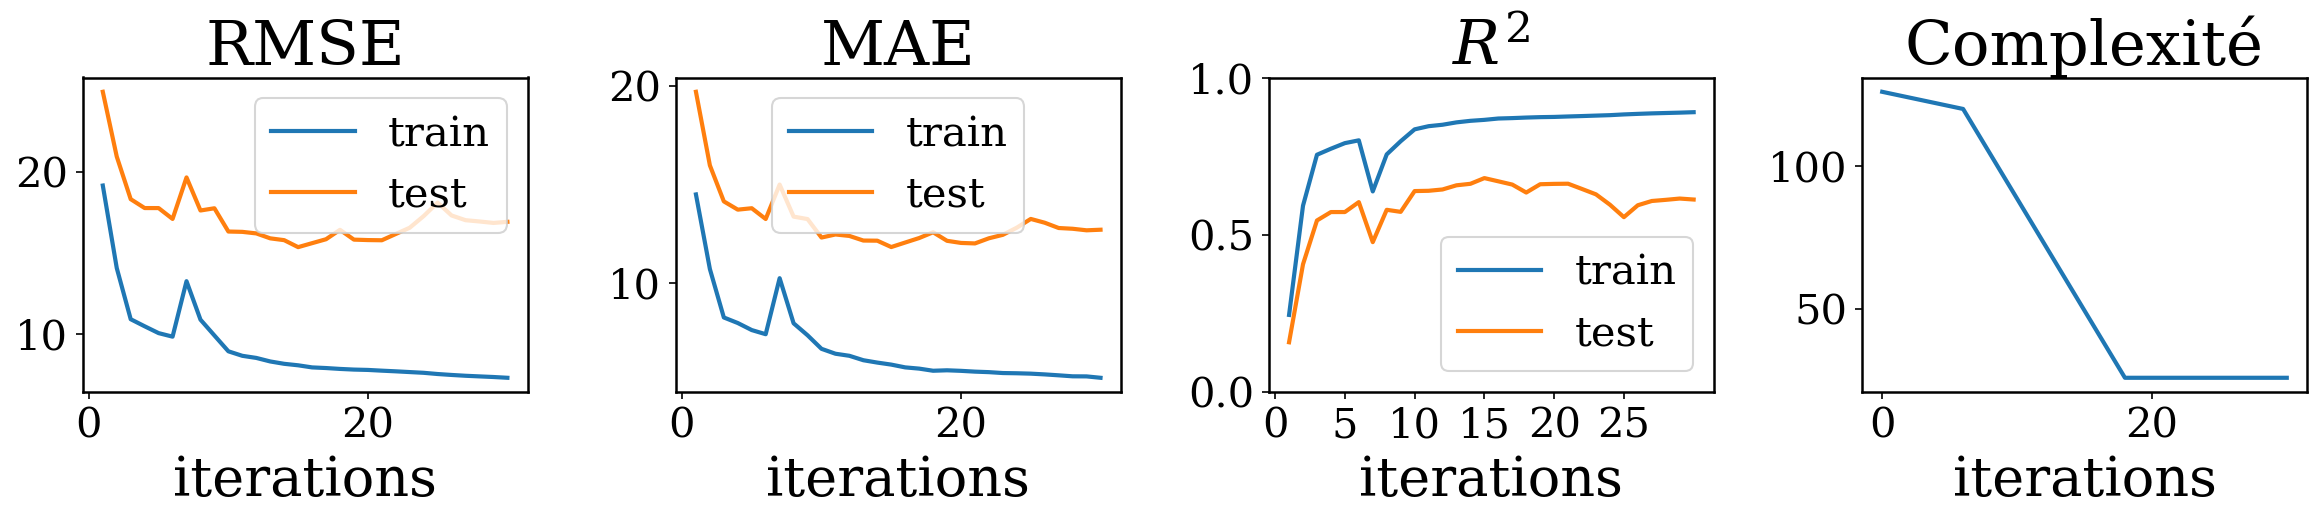

In [171]:

fig = plt.figure(figsize=(16, 4))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1])




#fig.suptitle(r"Evaluation de PDE-SINDy avec SR3($R=\ell_1$, $\lambda=1$, $\nu=1$)")
iters = iters_complet = np.arange(1, np.sum(steps_list)+1)
ax0 = fig.add_subplot(gs[0])
ax0.plot(iters_complet, np.sqrt(losses_total['mse_loss_train']), label='train')
ax0.plot(iters, np.sqrt(losses_total['mse_loss_test']), label='test')
ax0.legend()
ax0.set_title(r'RMSE')
ax0.set_xlabel('iterations')

ax1 = fig.add_subplot(gs[1])
ax1.plot(iters_complet, losses_total['l1_loss_train'], label='train')
ax1.plot(iters, losses_total['l1_loss_test'], label='test')
ax1.legend()
ax1.set_title(r'MAE')
ax1.set_xlabel('iterations')

ax2 = fig.add_subplot(gs[2])
ax2.plot(iters_complet, losses_total['r2_score_train'] , label='train')
ax2.plot(iters, losses_total['r2_score_test'] , label='test')
ax2.set_title(r'$R^2$')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.set_xlabel('iterations')
ax2.set_xticks([0, 5,10, 15, 20, 25])

ax3 = fig.add_subplot(gs[3])
ax3.plot(np.cumsum(steps_list), kan_compl, label='complexity')
ax3.set_title(r'Complexité')
ax3.set_xlabel('iterations')

fig.tight_layout()

plt.savefig(f'FIGURES/pb{num_pb}_metrics_kan.png', dpi=300, bbox_inches='tight', transparent=True)

plt.savefig(f'FIGURES/pb{num_pb}_metrics_kan.pdf', bbox_inches='tight', transparent=True, backend='pdf')
plt.show()




In [172]:
y.shape
x_fixed

5

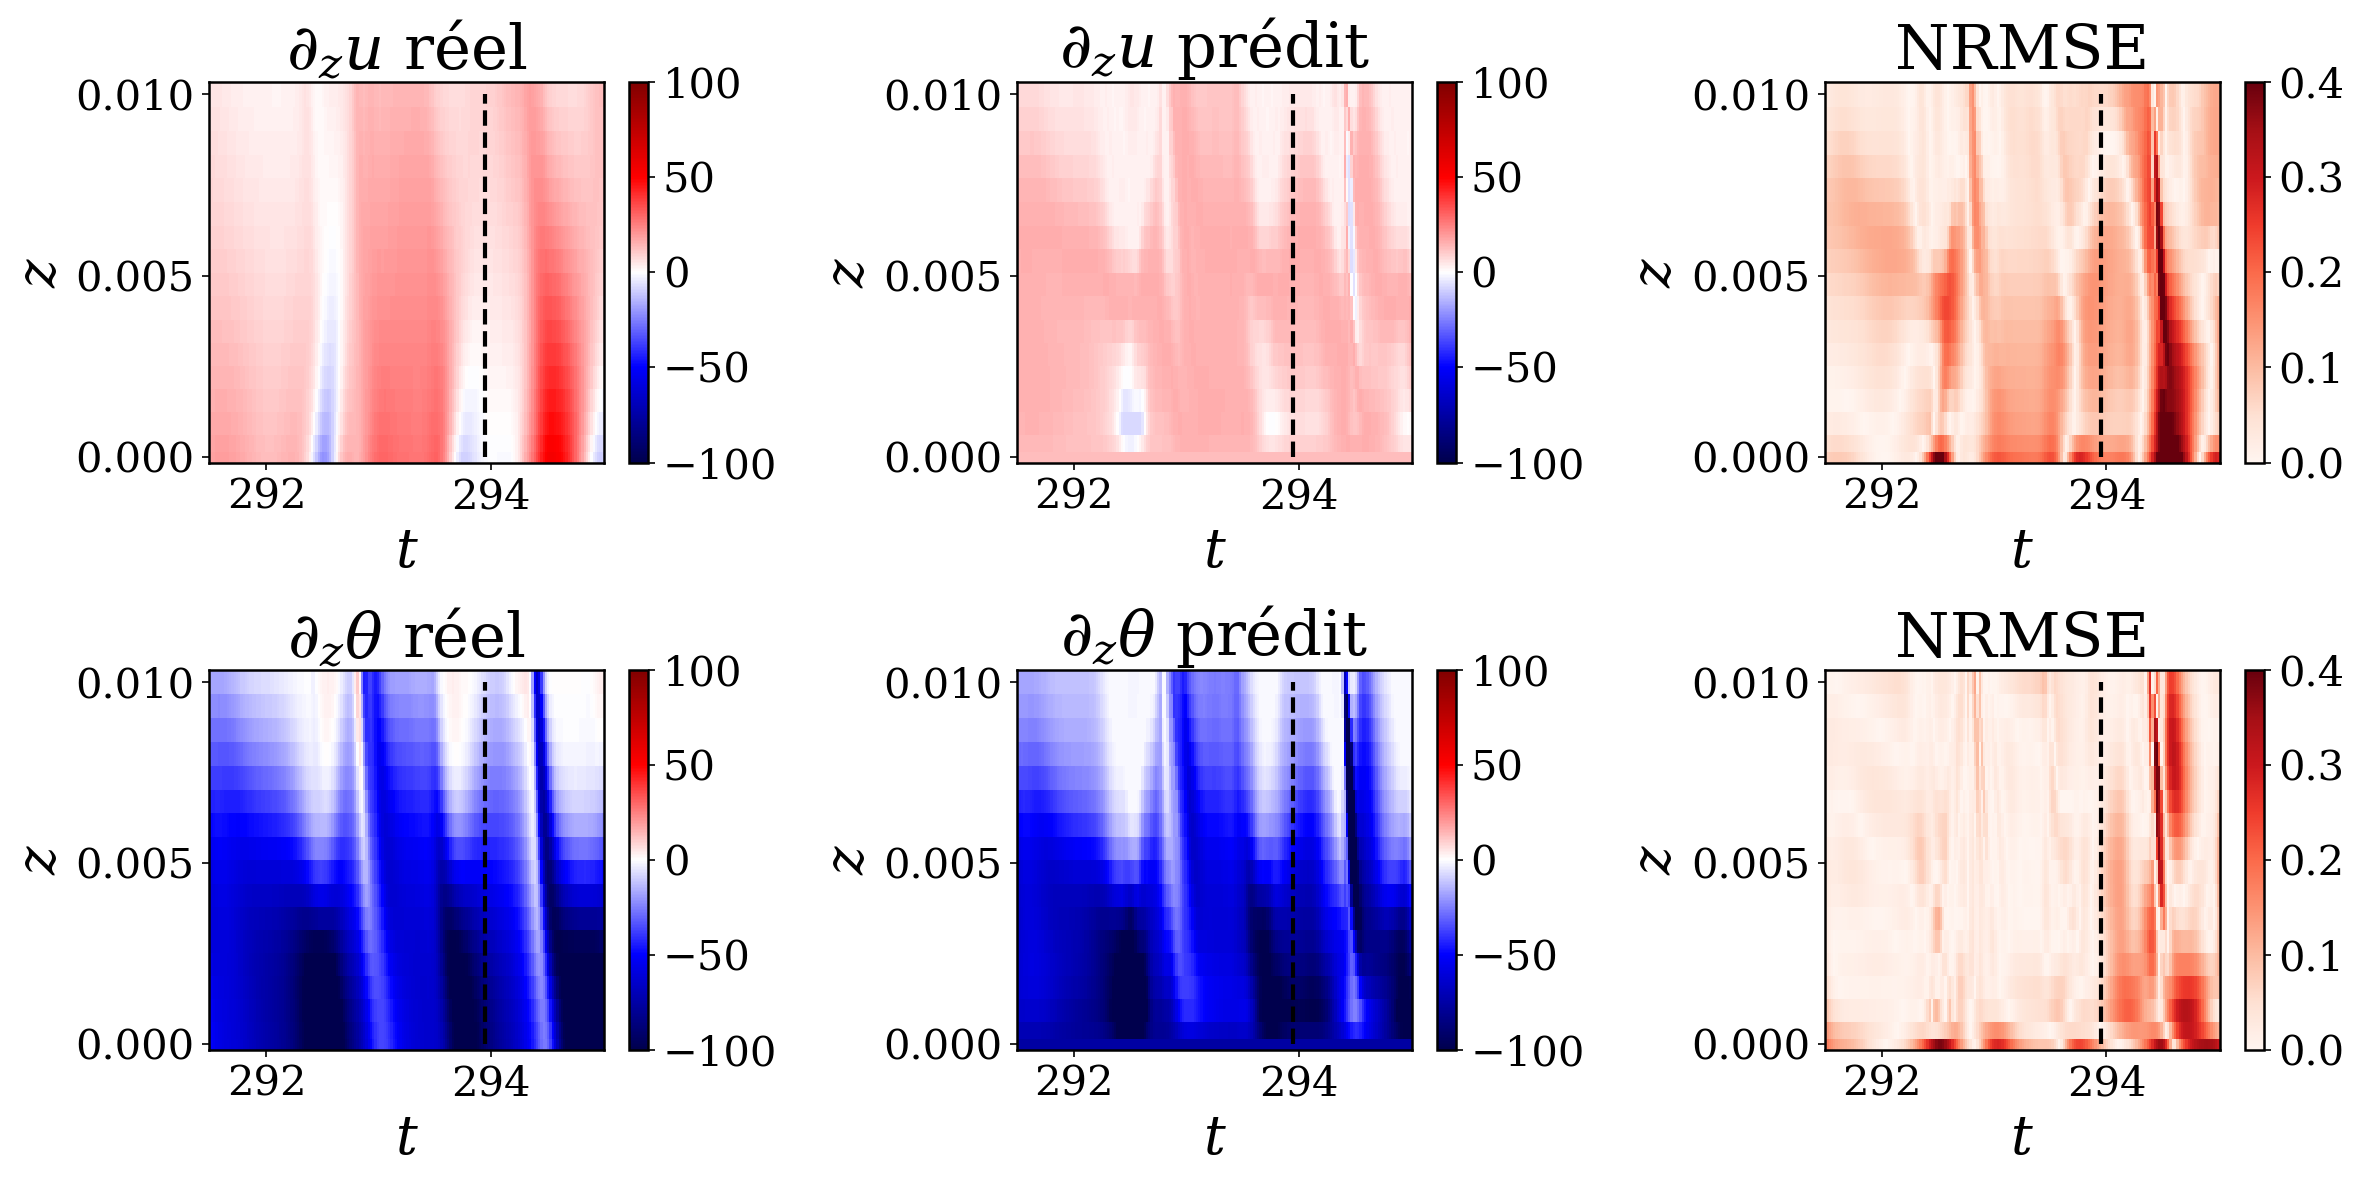

In [173]:
# SINDy

fig = plt.figure( figsize=(16,8))
ax1 = plt.subplot(2,3,1)
ax2 = plt.subplot(2,3,2)
ax3 = plt.subplot(2,3,3)
ax4 = plt.subplot(2,3,4)
ax5 = plt.subplot(2,3,5)
ax6 = plt.subplot(2,3,6)

res_norm = mcolors.Normalize(vmin=0.0, vmax=0.4)
norm = mcolors.TwoSlopeNorm(vmin=-100.0, vcenter=0.0, vmax=100.0)
# coeff_weak = model_weak.coefficients()
# pred_sindy = (X_transf @ coeff_weak.T)[:,:,[0,2]]

pred_train = model(data_kan['train_input']).detach().numpy().reshape(len(t_train), len(x), len(z), 2)
pred_test = model(data_kan['test_input']).detach().numpy().reshape(len(t_test),len(x), len(z), 2)
pred = np.concatenate((pred_train, pred_test), axis=0) 
pred_sindy = pred # unormalize(torch.from_numpy(pred), mean_y_kan, std_y_kan).detach().numpy()

# data_input = torch.concatenate([data_kan['train_input'], data_kan['test_input']], dim=0)
# pred_sindy = model(data_input).detach().numpy().reshape(len(z), len(t), 2)

x_fixed = x.size//2

im1 = ax1.pcolor(t, (z), y_kan[:,x_fixed,:,0].T, cmap='seismic', norm=norm)
ax1.vlines(t[train_id[-1]], (z[0]), (z[-1]), ls='dashed', colors='k', linewidth=2)
plt.colorbar(im1, ax=ax1)
ax1.set_title(r"$\partial_z u$ réel")
ax1.set_ylabel('$z$')
ax1.set_xlabel('$t$')


im2 = ax2.pcolor(t, (z), pred_sindy[:,x_fixed,:,0].T, cmap='seismic', norm=norm)
ax2.vlines(t[train_id[-1]], z[0], z[-1], ls='dashed', colors='k', linewidth=2)
plt.colorbar(im2, ax=ax2)
ax2.set_title(r"$\partial_z u$ prédit")
ax2.set_ylabel('$z$')
ax2.set_xlabel('$t$')


im3 = ax3.pcolor(t, (z), (np.sqrt((y_kan[:,x_fixed,:,0]-pred_sindy[:,x_fixed,:,0])**2)/(y_kan[:,:,0].max() - y_kan[:,x_fixed,:,0].min())).T, cmap='Reds', norm=res_norm)
ax3.vlines(t[train_id[-1]], z[0], z[-1], ls='dashed', colors='k', linewidth=2)
plt.colorbar(im3, ax=ax3)
ax3.set_title(r"NRMSE")
ax3.set_ylabel('$z$')
ax3.set_xlabel('$t$')

im4 = ax4.pcolor(t, (z), y_kan[:,x_fixed,:,1].T, cmap='seismic', norm=norm)
ax4.vlines(t[train_id[-1]], (z[0]), (z[-1]), ls='dashed', colors='k', linewidth=2)
plt.colorbar(im4, ax=ax4)
ax4.set_title(r"$\partial_z \theta$ réel")
ax4.set_ylabel('$z$')
ax4.set_xlabel('$t$')


im5 = ax5.pcolor(t, (z), pred_sindy[:,x_fixed,:,1].T, cmap='seismic', norm=norm)
ax5.vlines(t[train_id[-1]], z[0], z[-1], ls='dashed', colors='k', linewidth=2)
plt.colorbar(im5, ax=ax5)
ax5.set_title(r"$\partial_z \theta$ prédit")
ax5.set_ylabel('$z$')
ax5.set_xlabel('$t$')


im6 = ax6.pcolor(t, (z), (np.sqrt((y_kan[:,x_fixed,:,1]-pred_sindy[:,x_fixed,:,1])**2)/(y_kan[:,x_fixed,:,1].max() - y_kan[:,x_fixed,:,1].min())).T, cmap='Reds', norm=res_norm)
ax6.vlines(t[train_id[-1]], z[0], z[-1], ls='dashed', colors='k', linewidth=2)
plt.colorbar(im6, ax=ax6)
ax6.set_title(r"NRMSE")
ax6.set_ylabel('$z$')
ax6.set_xlabel('$t$')

fig.tight_layout(pad=0.5)
plt.savefig(f'FIGURES/pb{num_pb}_res_kan.png', dpi=300, bbox_inches='tight', transparent=True)

plt.savefig(f'FIGURES/pb{num_pb}_res_kan.pdf', bbox_inches='tight', transparent=True)
fig.show()


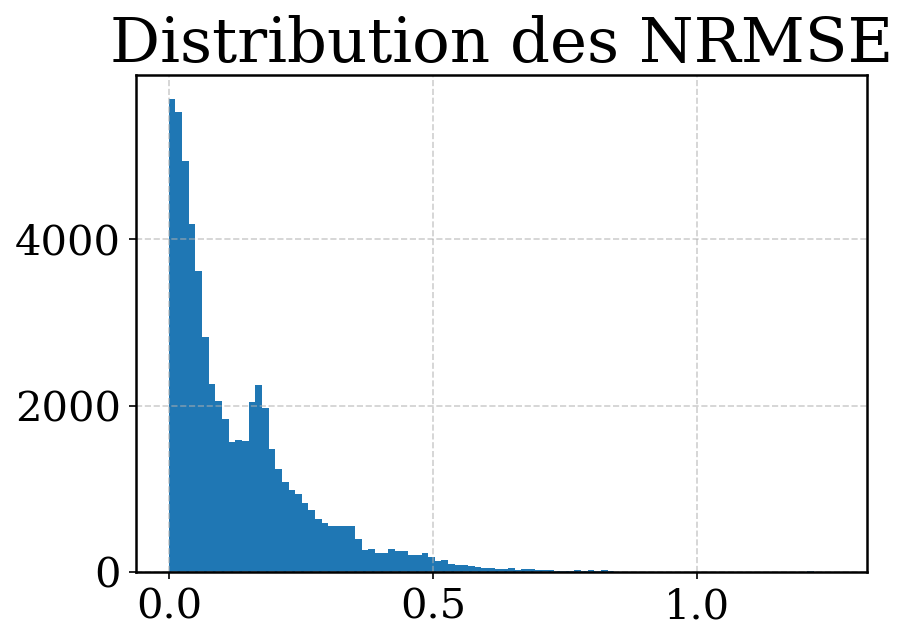

In [174]:


NRMSE = np.sqrt((y-pred_sindy)**2)/(y.max(axis=(0, 1)) - y.min(axis=(0, 1)))
plt.hist(NRMSE.flatten(), bins=100)

plt.title("Distribution des NRMSE")
plt.tight_layout()
plt.grid(True)
plt.savefig(f'FIGURES/pb{num_pb}_nrmse_kan.png', dpi=300, bbox_inches='tight', transparent=True)

plt.savefig(f'FIGURES/pb{num_pb}_nrmse_kan.pdf', bbox_inches='tight', transparent=True)
plt.show()


In [175]:
X_kan.shape

(174, 10, 17, 12)

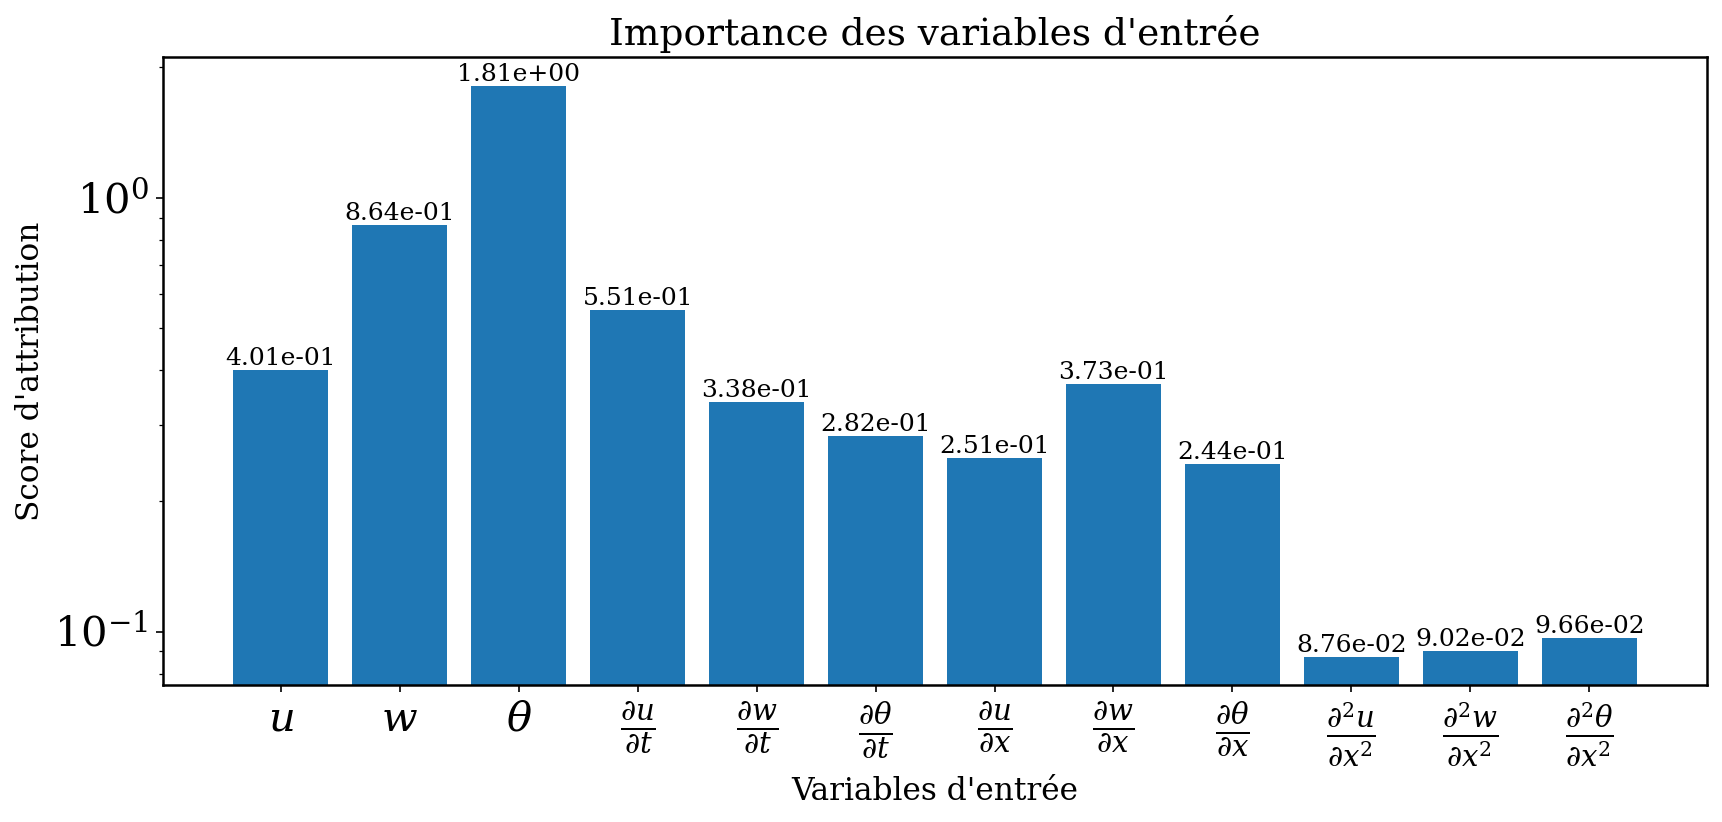

In [176]:
import numpy as np
import matplotlib.pyplot as plt

scores = model.feature_score.cpu().detach().numpy()
features = in_vars  # liste des noms des features

plt.figure(figsize=(12, 6))
bars = plt.bar(features, scores, color='tab:blue')

plt.yscale('log')
plt.xlabel('Variables d\'entrée', fontsize=15)
plt.ylabel('Score d\'attribution', fontsize=15)
plt.title("Importance des variables d'entrée", fontsize=18)
plt.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

# Optionnel : ajouter les valeurs au-dessus des barres
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height * 1.0,
             f'{height:.2e}', ha='center', va='bottom', fontsize=12)
plt.grid(False)
plt.tight_layout()
plt.savefig(f'FIGURES/pb{num_pb}_varimp_kan.png', dpi=300, bbox_inches='tight', transparent=True)

plt.savefig(f'FIGURES/pb{num_pb}_varimp_kan.pdf', bbox_inches='tight', transparent=True)
plt.show()


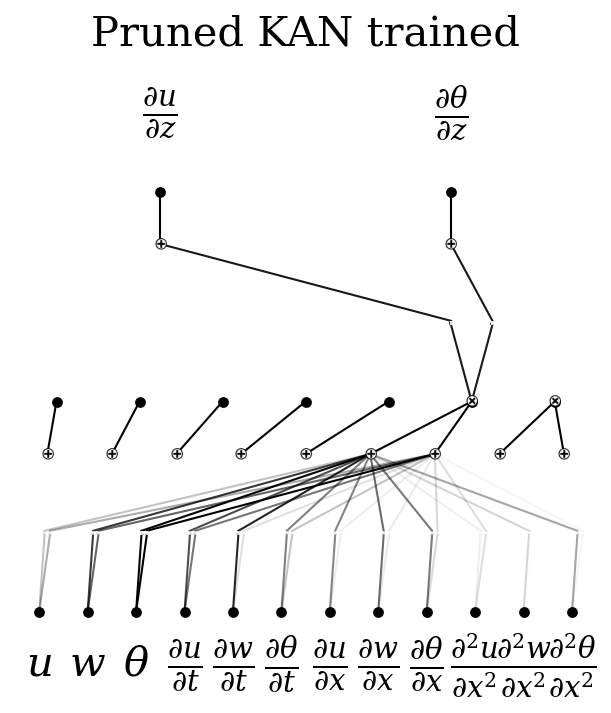

In [153]:
model.plot(in_vars=in_vars, out_vars=out_vars, title='Pruned KAN trained', folder= './FIGKAN/') # mettre juste 3 node addition 

## Symbolique KAN

In [202]:

data_kan['train_input'] = torch.tensor(X_kan[train_id].reshape(len(x)*len(z)*len(train_id), nb_features), dtype=torch.float32, device=device)
data_kan['test_input'] = torch.tensor(X_kan[test_id].reshape(len(z)*len(x)*len(test_id), nb_features), dtype=torch.float32, device=device)
data_kan['train_label'] = torch.tensor(y_kan[train_id,:,:,:].reshape(len(z)*len(x)*len(train_id), 2), dtype=torch.float32, device=device)
data_kan['test_label'] = torch.tensor(y_kan[test_id,:,:,:].reshape(len(z)*len(test_id)*len(x), 2), dtype=torch.float32, device=device)

In [228]:
# init and first train
num_pb=85
model = kan.KAN(width=[data_kan['test_input'].shape[-1], [0, 1], 2], grid=3, k=3, seed=1501, sparse_init=False)
np.random.seed(1501)
kan_compl = [12*(0+1*2) + (0+1*2)*2]
var_imp = []
steps_list = [0, 6, 12, 12]
losses = model.fit(
    data_kan, batch=-1, steps=steps_list[1], loss_fn=torch.nn.MSELoss(),
    update_grid = True, grid_update_num=3,
    lr = 5e-1, lamb=10, opt='LBFGS', 
    metrics=[torch.nn.functional.mse_loss, torch.nn.functional.l1_loss], log=1
)
var_imp.append(model.feature_score)
kan_compl.append( model.n_edge )



checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.23e+01 | test_loss: 2.00e+01 | reg: 1.24e+01 | : 100%|█| 6/6 [00:08<00:00,  1.39s/it

saving model version 0.1


In [229]:
#model.auto_symbolic(lib=['x', 'x^2', 'exp', 'log', '1/x'])
model.fix_symbolic(0, 0, 0, 'exp')
#model.fix_symbolic(0, 0, 1, 'x')
model.fix_symbolic(0, 1, 0, 'x^2')
model.fix_symbolic(0, 1, 1, 'x')
model.fix_symbolic(0, 2, 0, 'x^2')
#model.fix_symbolic(0, 2, 1, 'x')
#model.fix_symbolic(0, 3, 0, 'x')
model.fix_symbolic(0, 3, 1, 'x')
model.fix_symbolic(0, 4, 0, 'x')
model.fix_symbolic(0, 4, 1, 'x')
model.fix_symbolic(0, 5, 0, 'x')
model.fix_symbolic(0, 5, 1, 'x')
model.fix_symbolic(0, 6, 0, 'x')
model.fix_symbolic(0, 6, 1, 'x')
model.fix_symbolic(0, 7, 0, 'x')
model.fix_symbolic(0, 7, 1, 'x')
model.fix_symbolic(0, 8, 0, 'x^2')
model.fix_symbolic(0, 8, 1, 'x^2')
model.fix_symbolic(0, 9, 0, 'exp')
#model.fix_symbolic(0, 9, 1, 'x')
#model.fix_symbolic(0, 10, 0, 'x')
model.fix_symbolic(0, 10, 1, 'x')
#model.fix_symbolic(0, 11, 0, 'x')
#model.fix_symbolic(0, 11, 1, 'x')
model.fix_symbolic(1, 0, 0, 'x')
model.fix_symbolic(1, 0, 1, 'x')


r2 is 0.9630265235900879
saving model version 0.2
r2 is 0.9888533353805542
saving model version 0.3
r2 is 0.7152344584465027
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.4
r2 is 0.9827260375022888
saving model version 0.5
r2 is 0.3055564761161804
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.6
r2 is 0.37245774269104004
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.7
Best value at boundary.
r2 is 0.4836455285549164
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.8
r2 is 0.8089967370033264
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.9
r2 is 0.517449140548706
r2 is not very high, please double check if you are choosing the correct symbolic function.

tensor(0.3604)

In [230]:
# entrainement intermediaire
losses2 = model.fit(
    data_kan, batch=-1, steps=steps_list[2], loss_fn=torch.nn.MSELoss(),
    update_grid = False, grid_update_num=1,
    lr = 5e1, lamb=0.1, opt='LBFGS', 
    metrics=[torch.nn.functional.mse_loss, torch.nn.functional.l1_loss], log=1
)
var_imp.append(model.feature_score)
kan_compl.append( model.n_edge )

| train_loss: 1.12e+01 | test_loss: 1.61e+01 | reg: 2.93e+00 | : 100%|█| 12/12 [00:25<00:00,  2.10s/

saving model version 0.21


In [231]:


model.fix_symbolic(0, 0, 1, 'x^2')
model.fix_symbolic(0, 2, 1, 'x')
model.fix_symbolic(0, 3, 0, 'x')
model.fix_symbolic(0, 9, 1, 'x^2')
model.fix_symbolic(0, 10, 0, 'x')
model.fix_symbolic(0, 11, 0, 'x')
model.fix_symbolic(0, 11, 1, 'x')



r2 is 0.997071385383606
saving model version 0.22
r2 is 0.9009710550308228
saving model version 0.23
r2 is 0.7910197377204895
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.24
r2 is 0.9886143803596497
saving model version 0.25
r2 is 0.47757861018180847
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.26
r2 is 0.38711416721343994
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.27
r2 is 0.2956397533416748
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.28


tensor(0.2956)

In [225]:
model = model.rewind('0.28')

rewind to model version 1.28, renamed as 2.28


In [232]:
losses_total['mse_loss_test']

[716.72412109375,
 541.7372436523438,
 480.0597229003906,
 491.7916259765625,
 486.6228942871094,
 437.676513671875,
 415.072021484375,
 396.7806091308594,
 398.5218200683594,
 398.862548828125,
 394.7940979003906,
 389.1058044433594,
 1043.7916259765625,
 1331.022216796875,
 686.0709228515625,
 688.6959228515625,
 756.3169555664062,
 1081.486328125,
 1141.380859375,
 1298.1705322265625,
 1361.7337646484375,
 1861.732421875,
 2424.227294921875,
 3065.4453125,
 1493.472412109375,
 2211.939697265625,
 2014.8316650390625,
 1574.0782470703125,
 2059.784912109375,
 1607.917236328125,
 1959.555908203125,
 2110.289306640625,
 2035.133056640625,
 1658.6192626953125,
 2344.01708984375,
 1721.5491943359375]

In [233]:
# training post symbolic 
losses3 = model.fit(
    data_kan, batch=-1, steps=steps_list[3], loss_fn=torch.nn.MSELoss(),
    update_grid = False, grid_update_num=3,
    lr = 5e-2, lamb=.1, opt='LBFGS', 
    metrics=[torch.nn.functional.mse_loss, torch.nn.functional.l1_loss], log=1
)
var_imp.append(model.feature_score)
kan_compl.append(model.n_edge )

| train_loss: 1.10e+01 | test_loss: 1.62e+01 | reg: 0.00e+00 | : 100%|█| 12/12 [00:23<00:00,  1.97s/

saving model version 0.29


In [234]:
losses_total = {}
for k in losses.keys():
    losses_total[k] = losses[k] + losses2[k] + losses3[k] #+ losses33[k] 
losses_total['r2_score_train'] = 1 - losses_total['mse_loss_train'] / np.mean( (data_kan['train_label']-data_kan['train_label'].mean(axis=[0])).numpy()**2 )
losses_total['r2_score_test'] = 1 - losses_total['mse_loss_test'] / np.mean( (data_kan['test_label']-data_kan['test_label'].mean(axis=[0])).numpy()**2 )


print(r"Modèle KAN pruned avec LBFGS:")
print("     Nombre de coefficients d'apprentissage :", kan_compl[0])
print("     Complexité du modèle :", kan_compl[-1])
print("     R2 score | training : ", losses_total['r2_score_train'][-1], "| testing : ", losses_total['r2_score_test'][-1]) # r2 
print("     MSE score | training : ", losses_total['mse_loss_train'][-1], "| testing : ", losses_total['mse_loss_test'][-1]) # r2
print("     RMSE score | training : ", np.sqrt(losses_total['mse_loss_train'][-1]), "| testing : ", np.sqrt(losses_total['mse_loss_test'][-1])) # r2    
print("     MAE score | training : ", losses_total['l1_loss_train'][-1], "| testing : ",losses_total['l1_loss_test'][-1]) # mse
print('\n\n')


Modèle KAN pruned avec LBFGS:
     Nombre de coefficients d'apprentissage : 28
     Complexité du modèle : 0
     R2 score | training :  0.7487805249063826 | testing :  0.6435761642045751
     MSE score | training :  121.96728515625 | testing :  262.73052978515625
     RMSE score | training :  11.043879986501574 | testing :  16.208964488367425
     MAE score | training :  8.029012680053711 | testing :  12.178504943847656





In [214]:
1 - 122.926 / np.mean( (data_kan['train_label']-data_kan['train_label'].mean(axis=[0])).numpy()**2 )
1 - 288.1909 / np.mean( (data_kan['test_label']-data_kan['test_label'].mean(axis=[0])).numpy()**2 )

0.6090362771949958

In [189]:
data_kan['train_label'].mean(axis=[0])

tensor([ 11.0208, -49.2615])

In [190]:
losses_total['r2_score_test']

array([ 0.02764208,  0.246506  ,  0.36180247,  0.37732797,  0.39219074,
        0.42078532, -1.32900383,  0.21181738, -0.54211092,  0.39412853,
        0.3653734 ,  0.37935801,  0.40465438,  0.34543828,  0.39931366,
        0.42518152,  0.42570987,  0.38724651,  0.33257645,  0.37734118,
        0.36525797,  0.34301808,  0.26256412,  0.25942124,  0.35203724,
        0.29430527,  0.35261933,  0.33222856,  0.35335059,  0.3509364 ])

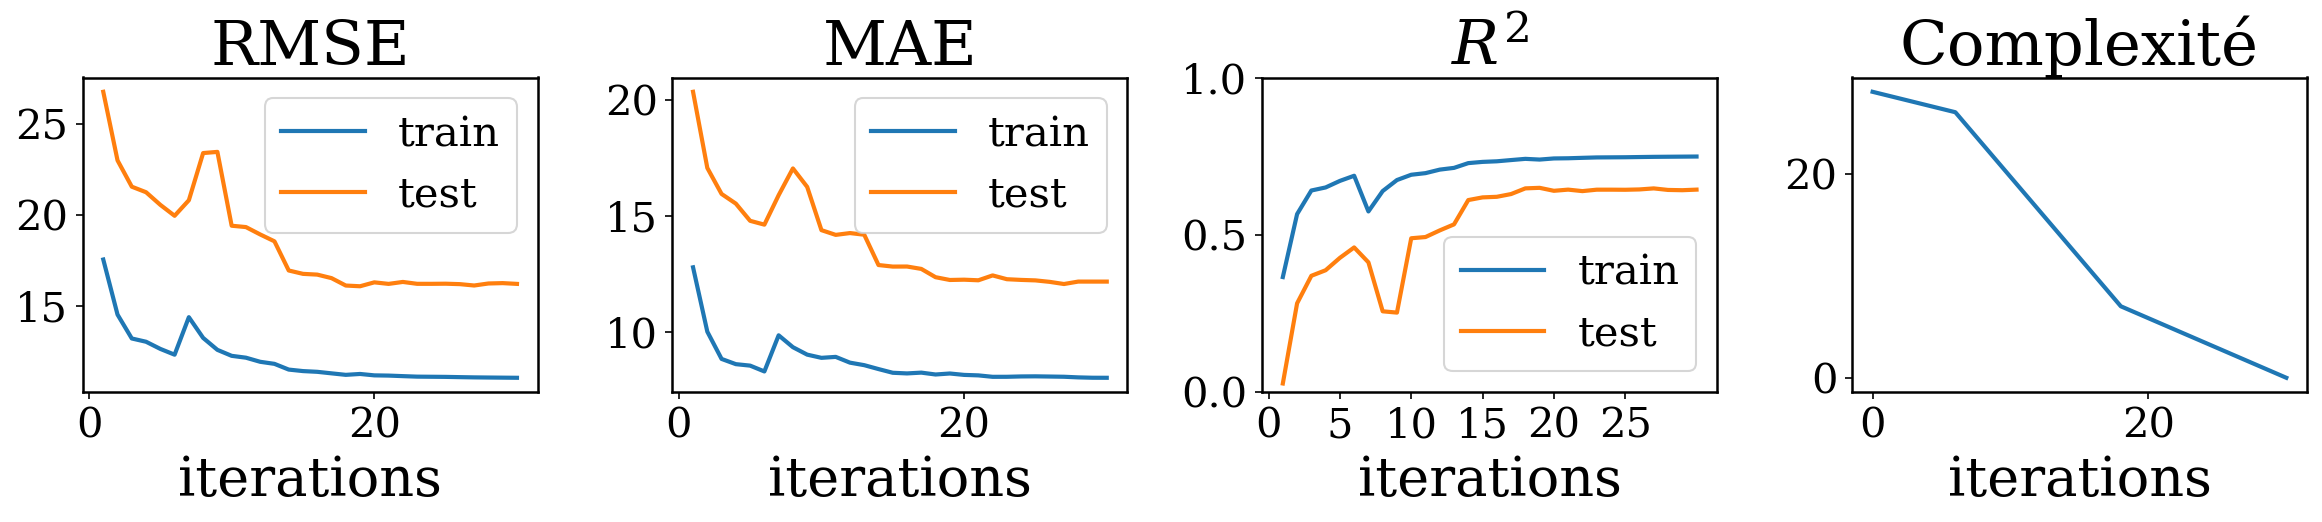

In [235]:

fig = plt.figure(figsize=(16, 4))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1])




#fig.suptitle(r"Evaluation de PDE-SINDy avec SR3($R=\ell_1$, $\lambda=1$, $\nu=1$)")
iters = iters_complet = np.arange(1, np.sum(steps_list)+1)
ax0 = fig.add_subplot(gs[0])
ax0.plot(iters_complet, np.sqrt(losses_total['mse_loss_train']), label='train')
ax0.plot(iters, np.sqrt(losses_total['mse_loss_test']), label='test')
ax0.legend()
ax0.set_title(r'RMSE')
ax0.set_xlabel('iterations')

ax1 = fig.add_subplot(gs[1])
ax1.plot(iters_complet, losses_total['l1_loss_train'], label='train')
ax1.plot(iters, losses_total['l1_loss_test'], label='test')
ax1.legend()
ax1.set_title(r'MAE')
ax1.set_xlabel('iterations')

ax2 = fig.add_subplot(gs[2])
ax2.plot(iters_complet, losses_total['r2_score_train'] , label='train')
ax2.plot(iters, losses_total['r2_score_test'] , label='test')
ax2.set_title(r'$R^2$')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.set_xlabel('iterations')
ax2.set_xticks([0, 5,10, 15, 20, 25])

ax3 = fig.add_subplot(gs[3])
ax3.plot(np.cumsum(steps_list), kan_compl, label='complexity')
ax3.set_title(r'Complexité')
ax3.set_xlabel('iterations')

fig.tight_layout()

plt.savefig(f'FIGURES/pb{num_pb}_metrics_kan.png', dpi=300, bbox_inches='tight', transparent=True)

plt.savefig(f'FIGURES/pb{num_pb}_metrics_kan.pdf', bbox_inches='tight', transparent=True, backend='pdf')
plt.show()




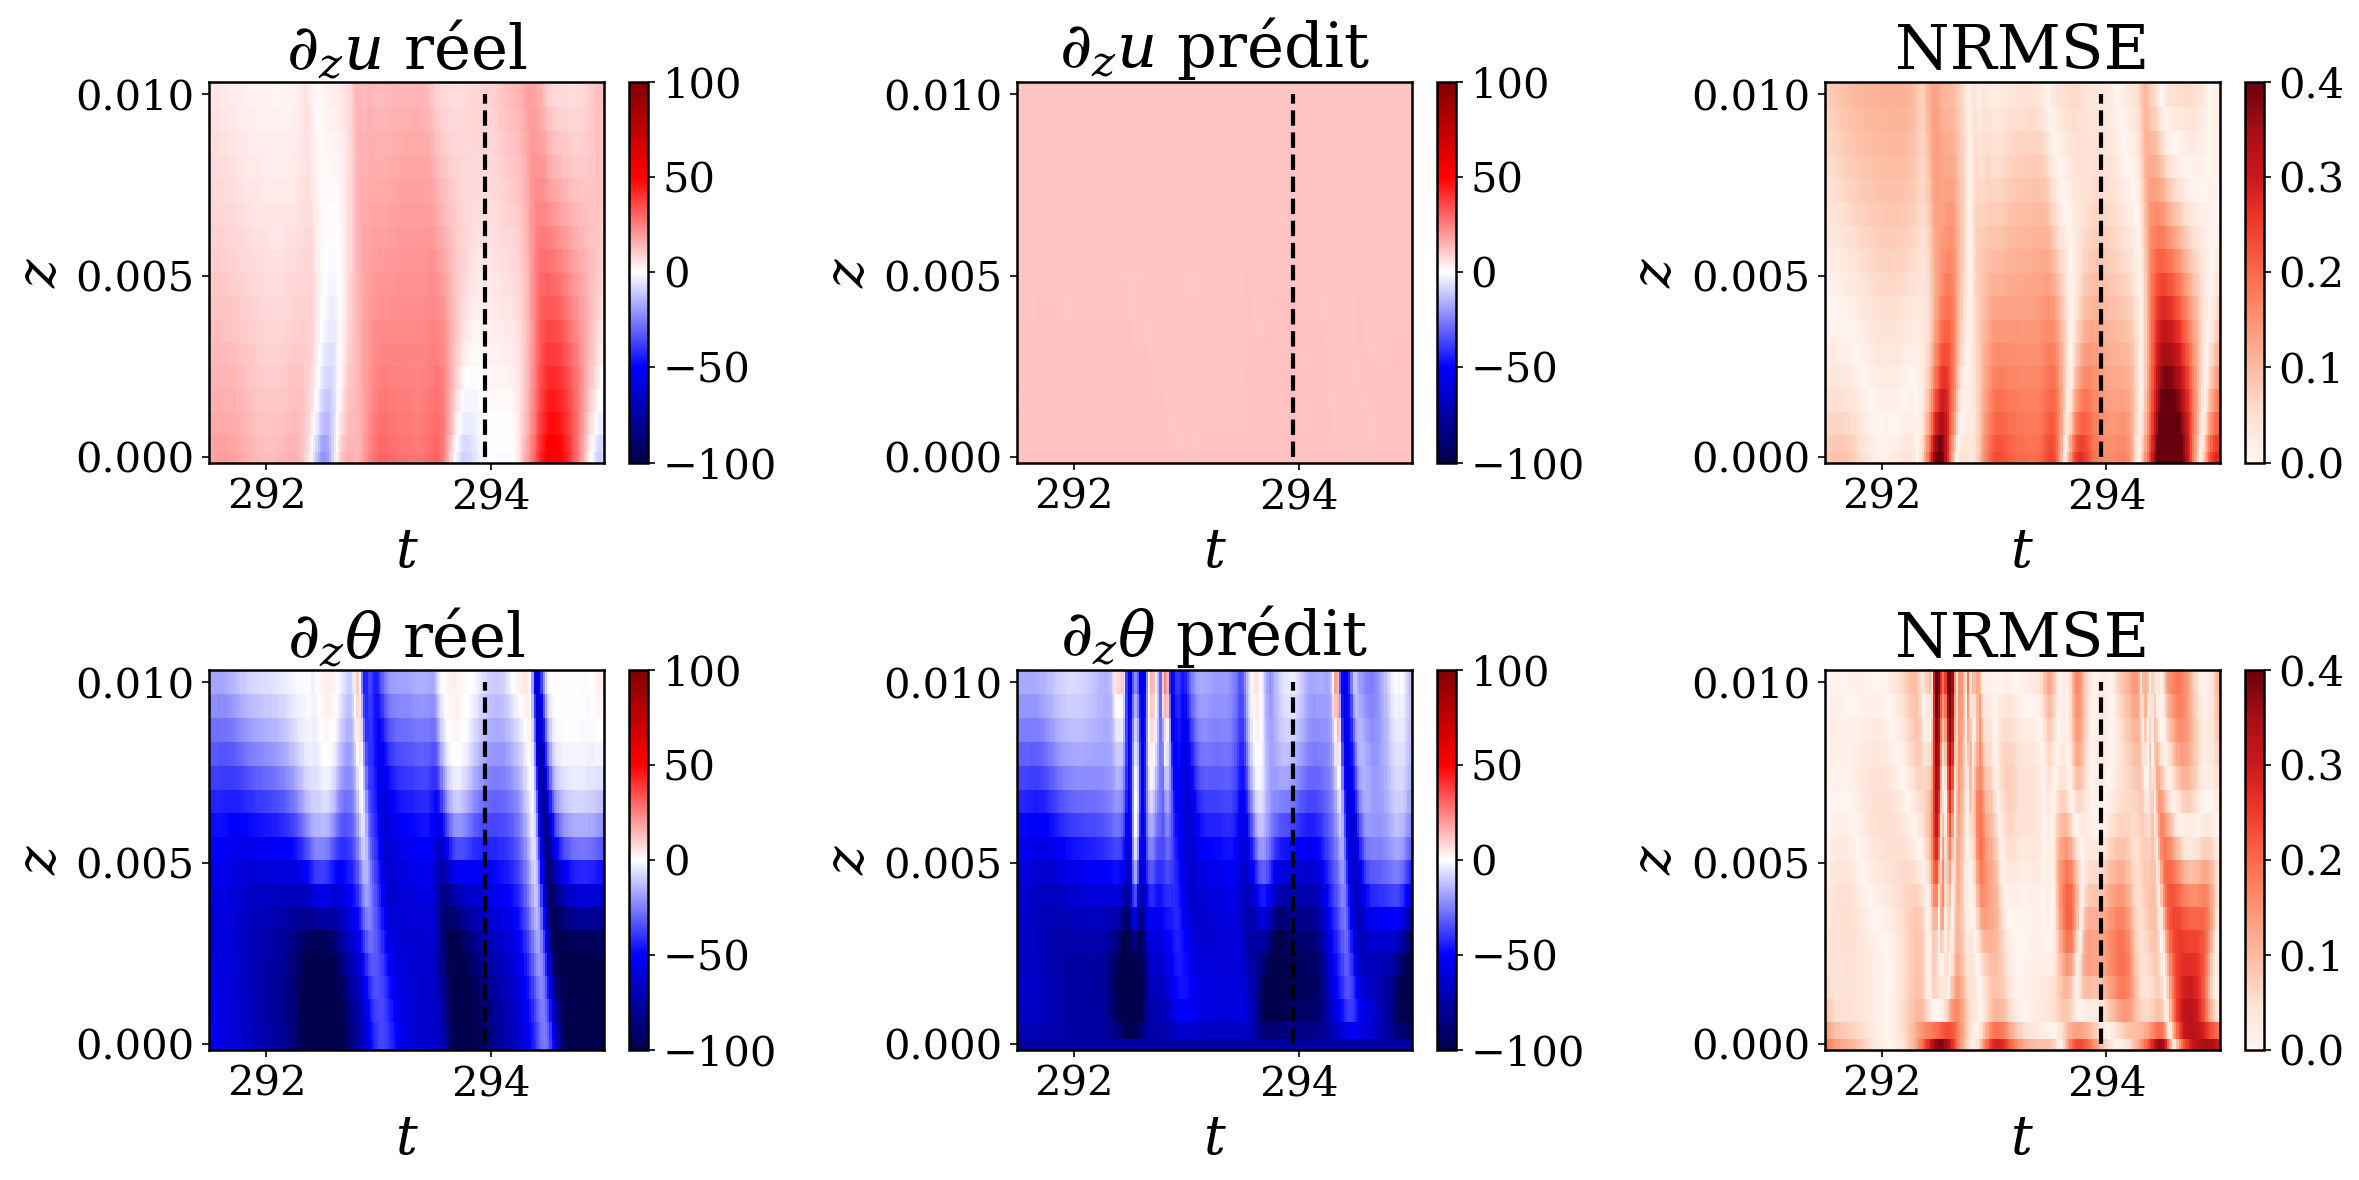

In [236]:
# SINDy

fig = plt.figure( figsize=(16,8))
ax1 = plt.subplot(2,3,1)
ax2 = plt.subplot(2,3,2)
ax3 = plt.subplot(2,3,3)
ax4 = plt.subplot(2,3,4)
ax5 = plt.subplot(2,3,5)
ax6 = plt.subplot(2,3,6)

res_norm = mcolors.Normalize(vmin=0.0, vmax=0.4)
norm = mcolors.TwoSlopeNorm(vmin=-100.0, vcenter=0.0, vmax=100.0)
unorm = mcolors.TwoSlopeNorm(vmin=-100.0, vcenter=0.0, vmax=100.0)
# coeff_weak = model_weak.coefficients()
# pred_sindy = (X_transf @ coeff_weak.T)[:,:,[0,2]]

pred_train = model(data_kan['train_input']).detach().numpy().reshape(len(t_train), len(x), len(z), 2)
pred_test = model(data_kan['test_input']).detach().numpy().reshape(len(t_test),len(x), len(z), 2)
pred = np.concatenate((pred_train, pred_test), axis=0) 
pred_sindy = pred # unormalize(torch.from_numpy(pred), mean_y_kan, std_y_kan).detach().numpy()

# data_input = torch.concatenate([data_kan['train_input'], data_kan['test_input']], dim=0)
# pred_sindy = model(data_input).detach().numpy().reshape(len(z), len(t), 2)

x_fixed = x.size//2

im1 = ax1.pcolor(t, (z), y_kan[:,x_fixed,:,0].T, cmap='seismic', norm=unorm)
ax1.vlines(t[train_id[-1]], (z[0]), (z[-1]), ls='dashed', colors='k', linewidth=2)
plt.colorbar(im1, ax=ax1)
ax1.set_title(r"$\partial_z u$ réel")
ax1.set_ylabel('$z$')
ax1.set_xlabel('$t$')


im2 = ax2.pcolor(t, (z), pred_sindy[:,x_fixed,:,0].T, cmap='seismic', norm=unorm)
ax2.vlines(t[train_id[-1]], z[0], z[-1], ls='dashed', colors='k', linewidth=2)
plt.colorbar(im2, ax=ax2)
ax2.set_title(r"$\partial_z u$ prédit")
ax2.set_ylabel('$z$')
ax2.set_xlabel('$t$')


im3 = ax3.pcolor(t, (z), (np.sqrt((y_kan[:,x_fixed,:,0]-pred_sindy[:,x_fixed,:,0])**2)/(y_kan[:,:,0].max() - y_kan[:,x_fixed,:,0].min())).T, cmap='Reds', norm=res_norm)
ax3.vlines(t[train_id[-1]], z[0], z[-1], ls='dashed', colors='k', linewidth=2)
plt.colorbar(im3, ax=ax3)
ax3.set_title(r"NRMSE")
ax3.set_ylabel('$z$')
ax3.set_xlabel('$t$')

im4 = ax4.pcolor(t, (z), y_kan[:,x_fixed,:,1].T, cmap='seismic', norm=norm)
ax4.vlines(t[train_id[-1]], (z[0]), (z[-1]), ls='dashed', colors='k', linewidth=2)
plt.colorbar(im4, ax=ax4)
ax4.set_title(r"$\partial_z \theta$ réel")
ax4.set_ylabel('$z$')
ax4.set_xlabel('$t$')


im5 = ax5.pcolor(t, (z), pred_sindy[:,x_fixed,:,1].T, cmap='seismic', norm=norm)
ax5.vlines(t[train_id[-1]], z[0], z[-1], ls='dashed', colors='k', linewidth=2)
plt.colorbar(im5, ax=ax5)
ax5.set_title(r"$\partial_z \theta$ prédit")
ax5.set_ylabel('$z$')
ax5.set_xlabel('$t$')


im6 = ax6.pcolor(t, (z), (np.sqrt((y_kan[:,x_fixed,:,1]-pred_sindy[:,x_fixed,:,1])**2)/(y_kan[:,x_fixed,:,1].max() - y_kan[:,x_fixed,:,1].min())).T, cmap='Reds', norm=res_norm)
ax6.vlines(t[train_id[-1]], z[0], z[-1], ls='dashed', colors='k', linewidth=2)
plt.colorbar(im6, ax=ax6)
ax6.set_title(r"NRMSE")
ax6.set_ylabel('$z$')
ax6.set_xlabel('$t$')

fig.tight_layout(pad=0.5)
plt.savefig(f'FIGURES/pb{num_pb}_res_kan.png', dpi=300, bbox_inches='tight', transparent=True)

plt.savefig(f'FIGURES/pb{num_pb}_res_kan.pdf', bbox_inches='tight', transparent=True)
fig.show()


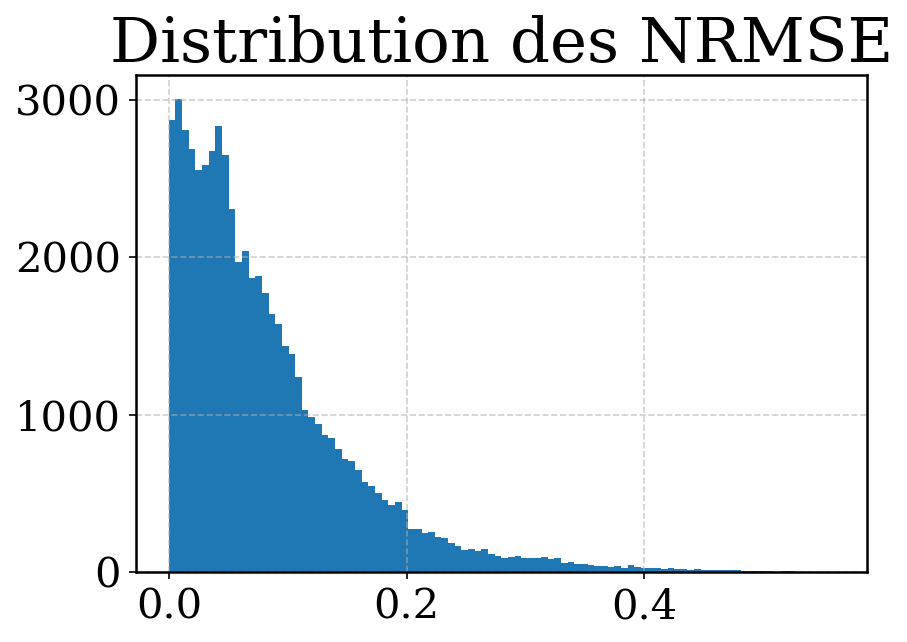

In [237]:


NRMSE = np.sqrt((y_sindy-pred_sindy)**2)/(y_sindy.max(axis=(0, 1, 2)) - y_sindy.min(axis=(0, 1, 2)))
plt.hist(NRMSE.flatten(), bins=100)

plt.title("Distribution des NRMSE")
plt.tight_layout()
plt.grid(True)
plt.savefig(f'FIGURES/pb{num_pb}_nrmse_kan.png', dpi=300, bbox_inches='tight', transparent=True)

plt.savefig(f'FIGURES/pb{num_pb}_nrmse_kan.pdf', bbox_inches='tight', transparent=True)
plt.show()


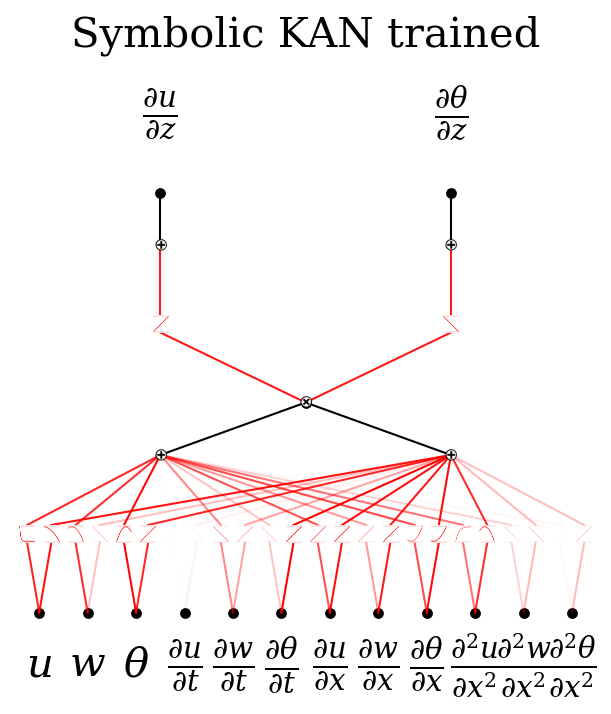

In [238]:
model.plot(in_vars=in_vars, out_vars=out_vars, title='Symbolic KAN trained', folder= './FIGKAN/') # mettre juste 3 node addition 

In [239]:
kan.ex_round(model.symbolic_formula()[0][0], 3)

0.015*(-0.76*x_11 + 0.06*x_12 + 0.019*x_4 - 1.407*x_5 - 0.458*x_6 + 1.801*x_7 + 1.264*x_8 - 4.904*(0.58 - x_3)**2 - 1.704*(-0.615*x_2 - 1)**2 + 0.751*(-0.633*x_9 - 1)**2 + 3.939 - 0.968*exp(-0.765*x_10) + 0.454*exp(-3.144*x_1))*(-0.078*x_11 + 0.037*x_12 - 0.04*x_2 + 0.232*x_3 - 0.009*x_4 + 0.071*x_5 + 0.422*x_6 + 0.256*x_7 + 0.295*x_8 - 0.146*(-0.573*x_1 - 1)**2 - 0.184*(-0.65*x_10 - 1)**2 + 0.275*(-0.337*x_9 - 1)**2 + 2.259) + 11.614

In [240]:
kan.ex_round(model.symbolic_formula()[0][1], 3)

-1.783*(-0.76*x_11 + 0.06*x_12 + 0.019*x_4 - 1.407*x_5 - 0.458*x_6 + 1.801*x_7 + 1.264*x_8 - 4.904*(0.58 - x_3)**2 - 1.704*(-0.615*x_2 - 1)**2 + 0.751*(-0.633*x_9 - 1)**2 + 3.939 - 0.968*exp(-0.765*x_10) + 0.454*exp(-3.144*x_1))*(-0.078*x_11 + 0.037*x_12 - 0.04*x_2 + 0.232*x_3 - 0.009*x_4 + 0.071*x_5 + 0.422*x_6 + 0.256*x_7 + 0.295*x_8 - 0.146*(-0.573*x_1 - 1)**2 - 0.184*(-0.65*x_10 - 1)**2 + 0.275*(-0.337*x_9 - 1)**2 + 2.259) - 52.35

## Un par un 

In [118]:
u_kan = {}
u_kan['train_input'] = torch.tensor(X_kan[train_id].reshape(len(x)*len(z)*len(train_id), nb_features), dtype=torch.float32, device=device)
u_kan['test_input'] = torch.tensor(X_kan[test_id].reshape(len(z)*len(x)*len(test_id), nb_features), dtype=torch.float32, device=device)
u_kan['train_label'] = torch.tensor(y_kan[train_id,:,:,0].reshape(len(z)*len(x)*len(train_id), 1), dtype=torch.float32, device=device)
u_kan['test_label'] = torch.tensor(y_kan[test_id,:,:,0].reshape(len(z)*len(test_id)*len(x), 1), dtype=torch.float32, device=device)

theta_kan = {}
theta_kan['train_input'] = torch.tensor(X_kan[train_id].reshape(len(x)*len(z)*len(train_id), nb_features), dtype=torch.float32, device=device)
theta_kan['test_input'] = torch.tensor(X_kan[test_id].reshape(len(z)*len(x)*len(test_id), nb_features), dtype=torch.float32, device=device)
theta_kan['train_label'] = torch.tensor(y_kan[train_id,:,:,1].reshape(len(z)*len(x)*len(train_id), 1), dtype=torch.float32, device=device)
theta_kan['test_label'] = torch.tensor(y_kan[test_id,:,:,1].reshape(len(z)*len(test_id)*len(x), 1), dtype=torch.float32, device=device)


In [119]:
# init and first train
num_pb=9
u_model = kan.KAN(width=[u_kan['test_input'].shape[-1], [0, 1], 1], grid=3, k=3, seed=1501, sparse_init=False)
theta_model = kan.KAN(width=[theta_kan['test_input'].shape[-1], [0, 1], 1], grid=3, k=3, seed=1501, sparse_init=False)

np.random.seed(1501)
kan_compl = [12*(0+1*2) + (0+1*2)*1]
var_imp = []
steps_list = [0, 6, 12, 12]
u_losses = u_model.fit(
    u_kan, batch=-1, steps=steps_list[1], loss_fn=torch.nn.MSELoss(),
    update_grid = True, grid_update_num=3,
    lr = 5e-1, lamb=10, opt='LBFGS', 
    metrics=[torch.nn.functional.mse_loss, torch.nn.functional.l1_loss], log=1
)
theta_losses = theta_model.fit(
    theta_kan, batch=-1, steps=steps_list[1], loss_fn=torch.nn.MSELoss(),
    update_grid = True, grid_update_num=3,
    lr = 5e-1, lamb=10, opt='LBFGS', 
    metrics=[torch.nn.functional.mse_loss, torch.nn.functional.l1_loss], log=1
)
#var_imp.append(model.feature_score)
kan_compl.append( u_model.n_edge + theta_model.n_edge )




checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.37e+01 | test_loss: 1.98e+01 | reg: 7.91e-01 | : 100%|█| 6/6 [00:07<00:00,  1.23s/it


saving model version 0.1


| train_loss: 1.43e+01 | test_loss: 2.71e+01 | reg: 1.91e+01 | : 100%|█| 6/6 [00:08<00:00,  1.37s/it

saving model version 0.1


In [120]:
u_model.auto_symbolic(lib=['x', 'x^2', 'exp', 'log', '1/x'])
theta_model.auto_symbolic(lib=['x', 'x^2', 'exp', 'log', '1/x'])



fixing (0,0,0) with x, r2=0.0654769018292427, c=1
fixing (0,0,1) with x, r2=0.14884230494499207, c=1
fixing (0,1,0) with x, r2=0.2761903405189514, c=1
fixing (0,1,1) with x, r2=0.08452415466308594, c=1
fixing (0,2,0) with x, r2=0.023309141397476196, c=1
fixing (0,2,1) with x, r2=0.042633820325136185, c=1
fixing (0,3,0) with x, r2=0.3260187804698944, c=1
fixing (0,3,1) with x, r2=0.42400091886520386, c=1
fixing (0,4,0) with x, r2=0.0451672300696373, c=1
fixing (0,4,1) with x, r2=0.00023730655084364116, c=1
fixing (0,5,0) with x, r2=0.6272842884063721, c=1
fixing (0,5,1) with x, r2=0.6097423434257507, c=1
fixing (0,6,0) with x, r2=0.08276419341564178, c=1
fixing (0,6,1) with x, r2=0.10462641716003418, c=1
fixing (0,7,0) with x, r2=0.004223625175654888, c=1
fixing (0,7,1) with exp, r2=0.9582841396331787, c=2
fixing (0,8,0) with x, r2=0.2790723443031311, c=1
fixing (0,8,1) with x, r2=0.13852466642856598, c=1
fixing (0,9,0) with x, r2=0.001949138822965324, c=1
fixing (0,9,1) with x, r2=0.55

In [121]:
1 - u_losses['mse_loss_test'] / np.mean( (u_kan['test_label']-u_kan['test_label'].mean(axis=[0])).numpy()**2 )

#1 - theta_losses['mse_loss_test'] / np.mean( (theta_kan['test_label']-theta_kan['test_label'].mean(axis=[0])).numpy()**2 )



array([-1.64445146, -1.64082766, -1.64082766, -1.64082766, -1.64082745,
       -1.64082766])

In [122]:
u_model.unfix_symbolic(0, 0, 0)
u_model.unfix_symbolic(0, 1, 1)
u_model.unfix_symbolic(0, 2, 0)
u_model.unfix_symbolic(0, 2, 1)
u_model.unfix_symbolic(0, 4, 0)
u_model.unfix_symbolic(0, 4, 1)
u_model.unfix_symbolic(0, 6, 0)
u_model.unfix_symbolic(0, 6, 1)
u_model.unfix_symbolic(0, 7, 0)
u_model.unfix_symbolic(0, 8, 1)
u_model.unfix_symbolic(0, 9, 0)
u_model.unfix_symbolic(0, 11, 0)

theta_model.unfix_symbolic(0, 1, 0)
theta_model.unfix_symbolic(0, 10, 0)


saving model version 0.3
saving model version 0.4
saving model version 0.5
saving model version 0.6
saving model version 0.7
saving model version 0.8
saving model version 0.9
saving model version 0.10
saving model version 0.11
saving model version 0.12
saving model version 0.13
saving model version 0.14
saving model version 0.3
saving model version 0.4


In [123]:
# entrainement intermediaire
u_losses2 = u_model.fit(
    u_kan, batch=-1, steps=steps_list[2], loss_fn=torch.nn.MSELoss(),
    update_grid = False, grid_update_num=1,
    lr = 5e1, lamb=0.1, opt='LBFGS', 
    metrics=[torch.nn.functional.mse_loss, torch.nn.functional.l1_loss], log=1
)
theta_losses2 = theta_model.fit(
    theta_kan, batch=-1, steps=steps_list[2], loss_fn=torch.nn.MSELoss(),
    update_grid = False, grid_update_num=1,
    lr = 5e1, lamb=0.1, opt='LBFGS', 
    metrics=[torch.nn.functional.mse_loss, torch.nn.functional.l1_loss], log=1
)
#var_imp.append(model.feature_score)
kan_compl.append( u_model.n_edge + theta_model.n_edge )

| train_loss: 6.82e+00 | test_loss: 1.32e+01 | reg: 1.28e+00 | : 100%|█| 12/12 [00:27<00:00,  2.27s/


saving model version 0.15


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 12/12 [00:27<00:00,  2.26s/it]

saving model version 0.5


In [126]:
theta_model = theta_model.rewind('0.1')

theta_losses2 = theta_model.fit(
    theta_kan, batch=-1, steps=steps_list[2], loss_fn=torch.nn.MSELoss(),
    update_grid = False, grid_update_num=1,
    lr = 5e1, lamb=0.1, opt='LBFGS', 
    metrics=[torch.nn.functional.mse_loss, torch.nn.functional.l1_loss], log=1
)

rewind to model version 1.1, renamed as 2.1


| train_loss: 1.29e+01 | test_loss: 2.68e+01 | reg: 2.34e+01 | : 100%|█| 12/12 [00:20<00:00,  1.74s/

saving model version 1.2


In [127]:
kan_compl[-1] = u_model.n_edge + theta_model.n_edge
u_model.auto_symbolic(lib=['x', 'x^2', 'exp', 'log', '1/x'])
theta_model.auto_symbolic(lib=['x', 'x^2', 'exp', 'log', '1/x'])



fixing (0,0,0) with x, r2=0.8943036198616028, c=1
skipping (0,0,1) since already symbolic
skipping (0,1,0) since already symbolic
fixing (0,1,1) with x, r2=0.5116012692451477, c=1
fixing (0,2,0) with x^2, r2=0.9992154240608215, c=2
fixing (0,2,1) with x, r2=0.9158815145492554, c=1
skipping (0,3,0) since already symbolic
skipping (0,3,1) since already symbolic
fixing (0,4,0) with x, r2=0.348660945892334, c=1
fixing (0,4,1) with x, r2=0.30896472930908203, c=1
skipping (0,5,0) since already symbolic
skipping (0,5,1) since already symbolic
fixing (0,6,0) with x, r2=0.014907695353031158, c=1
fixing (0,6,1) with x, r2=0.508101224899292, c=1
fixing (0,7,0) with x, r2=0.7821444869041443, c=1
skipping (0,7,1) since already symbolic
skipping (0,8,0) since already symbolic
fixing (0,8,1) with x, r2=0.4703504145145416, c=1
fixing (0,9,0) with x, r2=0.25764763355255127, c=1
skipping (0,9,1) since already symbolic
skipping (0,10,0) since already symbolic
skipping (0,10,1) since already symbolic
fixi

In [128]:
# training post symbolic 
u_losses3 = u_model.fit(
    u_kan, batch=-1, steps=steps_list[3], loss_fn=torch.nn.MSELoss(),
    update_grid = False, grid_update_num=3,
    lr = 5e-2, lamb=.1, opt='LBFGS', 
    metrics=[torch.nn.functional.mse_loss, torch.nn.functional.l1_loss], log=1
)

theta_losses3 = theta_model.fit(
    theta_kan, batch=-1, steps=steps_list[3], loss_fn=torch.nn.MSELoss(),
    update_grid = False, grid_update_num=3,
    lr = 5e-2, lamb=.1, opt='LBFGS', 
    metrics=[torch.nn.functional.mse_loss, torch.nn.functional.l1_loss], log=1
)

kan_compl.append( u_model.n_edge + theta_model.n_edge )

| train_loss: 6.31e+00 | test_loss: 3.42e+01 | reg: 0.00e+00 | : 100%|█| 12/12 [00:19<00:00,  1.66s/


saving model version 0.17


| train_loss: 5.77e+01 | test_loss: 5.85e+01 | reg: 0.00e+00 | : 100%|█| 12/12 [00:01<00:00,  6.76it

saving model version 1.4


In [131]:
u_losses3['mse_loss_test']

[179.6072998046875,
 526.2822265625,
 608.0030517578125,
 590.1157836914062,
 587.2447509765625,
 587.093505859375,
 587.0716552734375,
 586.8890991210938,
 586.8557739257812,
 585.5317993164062,
 571.6192626953125,
 1167.792724609375]

In [132]:
u_losses3['mse_loss_test']
theta_losses3['mse_loss_test']

[3428.0107421875,
 3428.010986328125,
 3428.01123046875,
 3428.01123046875,
 3428.01123046875,
 3428.01123046875,
 3428.010986328125,
 3428.01123046875,
 3428.010986328125,
 3428.010986328125,
 3428.010986328125,
 3428.01123046875]

In [133]:
u_losses_total = {}
for k in losses.keys():
    u_losses_total[k] = u_losses[k] + u_losses2[k] + u_losses3[k] #+ losses33[k] 
u_losses_total['r2_score_train'] = 1 - u_losses_total['mse_loss_train'] / np.mean( (u_kan['train_label']-u_kan['train_label'].mean(axis=[0])).numpy()**2 )
u_losses_total['r2_score_test'] = 1 - u_losses_total['mse_loss_test'] / np.mean( (u_kan['test_label']-u_kan['test_label'].mean(axis=[0])).numpy()**2 )
u_losses_total['r2_score_test'][-1]

-6.863747922642036